### Imports e Configurações

In [184]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [185]:
import warnings
warnings.filterwarnings('ignore')

In [186]:
import yfinance as yf

from datetime import datetime, timedelta, timezone

from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, MinMaxScaler

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import kstest_normal,het_arch, acorr_ljungbox
from statsmodels.tsa.stattools import acf, q_stat, adfuller, kpss

from scipy.stats import probplot, moment, shapiro, jarque_bera

import pmdarima as pm

In [187]:
seed = 2022 

In [188]:
pd.set_option('display.max_colwidth', None)

In [189]:
img_dir = os.path.join('..', 'img')

### Funções Uteis

In [190]:
# Calcular a volatilidade realizada diaria
def realized_volatility_daily(series_log_return):
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))
    # return np.sqrt(np.sum(series_log_return**2))
# Calcular a volatilidade realizada diaria
def realized_volatility(series_log_return):
    n = len(series_log_return)
    # return np.sqrt(np.sum(series_log_return**2)/(n - 1))
    return np.sqrt(np.sum(series_log_return**2))

def transform_volatility_to_scaler(scaler, tf_series):
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output


In [191]:
def RMSPE(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def MSE(y_true, y_pred):
    return mse(y_true, y_pred)

def RMSE(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))  
     
def MAPE(y_true, y_pred): 
    return mean_absolute_percentage_error(y_true, y_pred) 

In [192]:
def get_resid_garch(model):
    gm_resid = model.resid
    gm_std = model.conditional_volatility
    return gm_resid / gm_std

def pvalue_ljungbox(values):
    return acorr_ljungbox(values, lags=[10]).lb_pvalue.iloc[0]

def pvalue_het_arch(values):
    return het_arch(values)[1]

def pvalue_shapiro(values):
    return shapiro(values)[1]

In [310]:
perf_df = pd.DataFrame(columns=['Validation MSE', 'Validation RMSPE', 'Validation RMSE', "MAPE"])
analysis_df = pd.DataFrame(columns=['AIC', 'BIC', 'LB', 'LB(r²)', 'ARCH', 'SW'])

def log_perf(y_true, y_pred, model_name):
    perf_df.loc[model_name] = [
        MSE(y_true, y_pred),
        RMSPE(y_true, y_pred), 
        RMSE(y_true, y_pred), 
        MAPE(y_true, y_pred)
    ]
    return perf_df

def log_garch(model, model_name, isNormal = True):
    analysis_df.loc[model_name] = [
        model.aic,
        model.bic,
        pvalue_ljungbox(get_resid_garch(model)),
        pvalue_ljungbox(get_resid_garch(model)**2),
        pvalue_het_arch(get_resid_garch(model)),
        pvalue_shapiro(get_resid_garch(model)) if isNormal else np.nan
    ]
    return analysis_df

def reset_log_garch():
    analysis_df = pd.DataFrame(columns=[ 'AIC', 'BIC', 'LB', 'LB(r²)', 'ARCH', 'SW'])

In [194]:
def correlogram(x, lags, title):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0],grid= True, color='red')
    q_p = np.max(q_stat(acf(x,lags), len(x))[1])
    stats= f'ADF:{adfuller(x)[1]:.2f},\nQ-Stat:{q_p:.2f}'
    axes[0][0].text(x=.03, y=.85,s=stats, transform=axes[0][0].transAxes)
    
    #probability plot 
    probplot(x, plot=axes[0][1])
    mean, variance, skewness, kurtosis = moment(x, moment=[1, 2, 3, 4])
    stats1 = f'Mean: {mean:.2f}\nSD: {np.sqrt(variance):.2f}\nSkew: {skewness:.2f}\nKurtosis:{kurtosis:.2f}'
    axes[0][1].text(x=.02, y=.75,s=stats1, transform=axes[0][1].transAxes)
    
    #ACF and PACF plots
    plot_acf(x, lags=lags, zero=False, ax=axes[1][0],alpha=0.05,)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [195]:
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

In [196]:
### GARCH FUNTIONS
def scale_tf_cond_vol(model_result):
    cond_vol = model_result.conditional_volatility
    scaler = MinMaxScaler()
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))
    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

In [197]:
copyDf = df

In [198]:
# Define the headers since the data does not have any
headers = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration",
           "num_doors", "body_style", "drive_wheels", "engine_location",
           "wheel_base", "length", "width", "height", "curb_weight",
           "engine_type", "num_cylinders", "engine_size", "fuel_system",
           "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm",
           "city_mpg", "highway_mpg", "price"]
exemple= pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
                  header=None, names=headers, na_values="?" )

In [199]:
exemple

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0


In [200]:
exemple.groupby(['make']).agg({
    'price': 'sum',
    'length': 'mean'
})

,price,length
make,,
alfa-romero,46495.0,169.600000
audi,107155.0,183.828571
bmw,208950.0,184.500000
chevrolet,18021.0,151.933333
dodge,70879.0,160.988889
honda,106401.0,160.769231
isuzu,17833.0,163.775000
jaguar,103800.0,196.966667
mazda,181099.0,170.805882


In [201]:
exemple = exemple.astype({'make': 'string'})

In [202]:
exemple.dtypes

symboling              int64
normalized_losses    float64
make                  string
fuel_type             object
aspiration            object
num_doors             object
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_cylinders         object
engine_size            int64
fuel_system           object
bore                 float64
stroke               float64
compression_ratio    float64
horsepower           float64
peak_rpm             float64
city_mpg               int64
highway_mpg            int64
price                float64
dtype: object

### Analise Exploratória 

In [203]:
start = datetime(2015, 1, 1)
end = datetime(2022, 10, 1)
start_covid = datetime(2020,2,20)
end_covid = datetime(2021, 1, 1)

In [204]:
ticker_name = "^BVSP"
ticker = yf.Ticker(ticker_name)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

In [205]:
## Interpolar Time series (Preencher valores nulos)
date_range = pd.date_range(
    start=start, 
    end=end,
    freq='D'
  )
data = df.reset_index()
data['Date'] = data['Date'].astype('datetime64[ns]')
data_aux = pd.DataFrame({'Date': date_range })
data = pd.merge(data_aux, data, on='Date', how='left')
data = data.set_index(["Date"], drop=True)  
data.interpolate(method='linear', inplace=True)
data = df.reset_index()
data['Date'] =data['Date'].apply(lambda x: x.replace(tzinfo=None))
data_aux = pd.DataFrame({'Date': date_range })
data = pd.merge(data_aux, data, on='Date', how='left')
data = data.set_index(["Date"], drop=True)  
data.interpolate(method='linear', inplace=True)


In [206]:
data = data.dropna()

In [207]:
df = data

Inserir Variavies Dummy

In [208]:
df['covid'] = df.index.map(lambda date : 1 if date > start_covid and date < end_covid else 0)

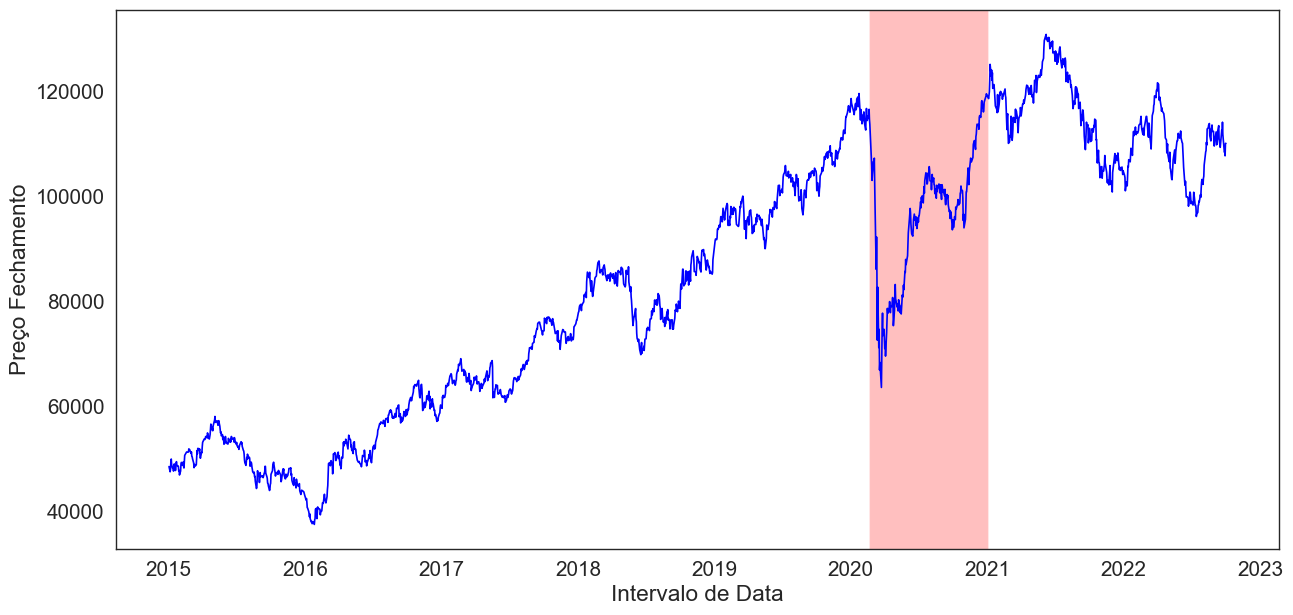

In [209]:
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(15,7))
    ax1.plot(df.Close, color='blue', label='Preço Fechamento')  
    plt.xlabel('Intervalo de Data')
    plt.ylabel('Preço Fechamento')
    ax1.axvspan(start_covid,end_covid, facecolor='red', alpha=0.25)
    plt.show()


In [210]:
df['returns'] = 100 * df['Close'].pct_change().dropna()

LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

In [211]:
df['log_returns'] = np.log(df['Close']/df['Close'].shift(1))

In [212]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,covid,returns,log_returns
Date,,,,,,,,,,
2015-01-02,50005.000000,50005.000000,48345.000000,48512.000000,2882100.0,0.0,0.0,0,NaN,NaN
2015-01-03,49507.333333,49507.333333,47984.666667,48180.333333,3210100.0,0.0,0.0,0,-0.683680,-0.006860
2015-01-04,49009.666667,49009.666667,47624.333333,47848.666667,3538100.0,0.0,0.0,0,-0.688386,-0.006908


In [213]:
df.dropna(inplace=True)

In [214]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,covid,returns,log_returns
Date,,,,,,,,,,
2015-01-03,49507.333333,49507.333333,47984.666667,48180.333333,3210100.0,0.0,0.0,0,-0.683680,-0.006860
2015-01-04,49009.666667,49009.666667,47624.333333,47848.666667,3538100.0,0.0,0.0,0,-0.688386,-0.006908
2015-01-05,48512.000000,48512.000000,47264.000000,47517.000000,3866100.0,0.0,0.0,0,-0.693158,-0.006956


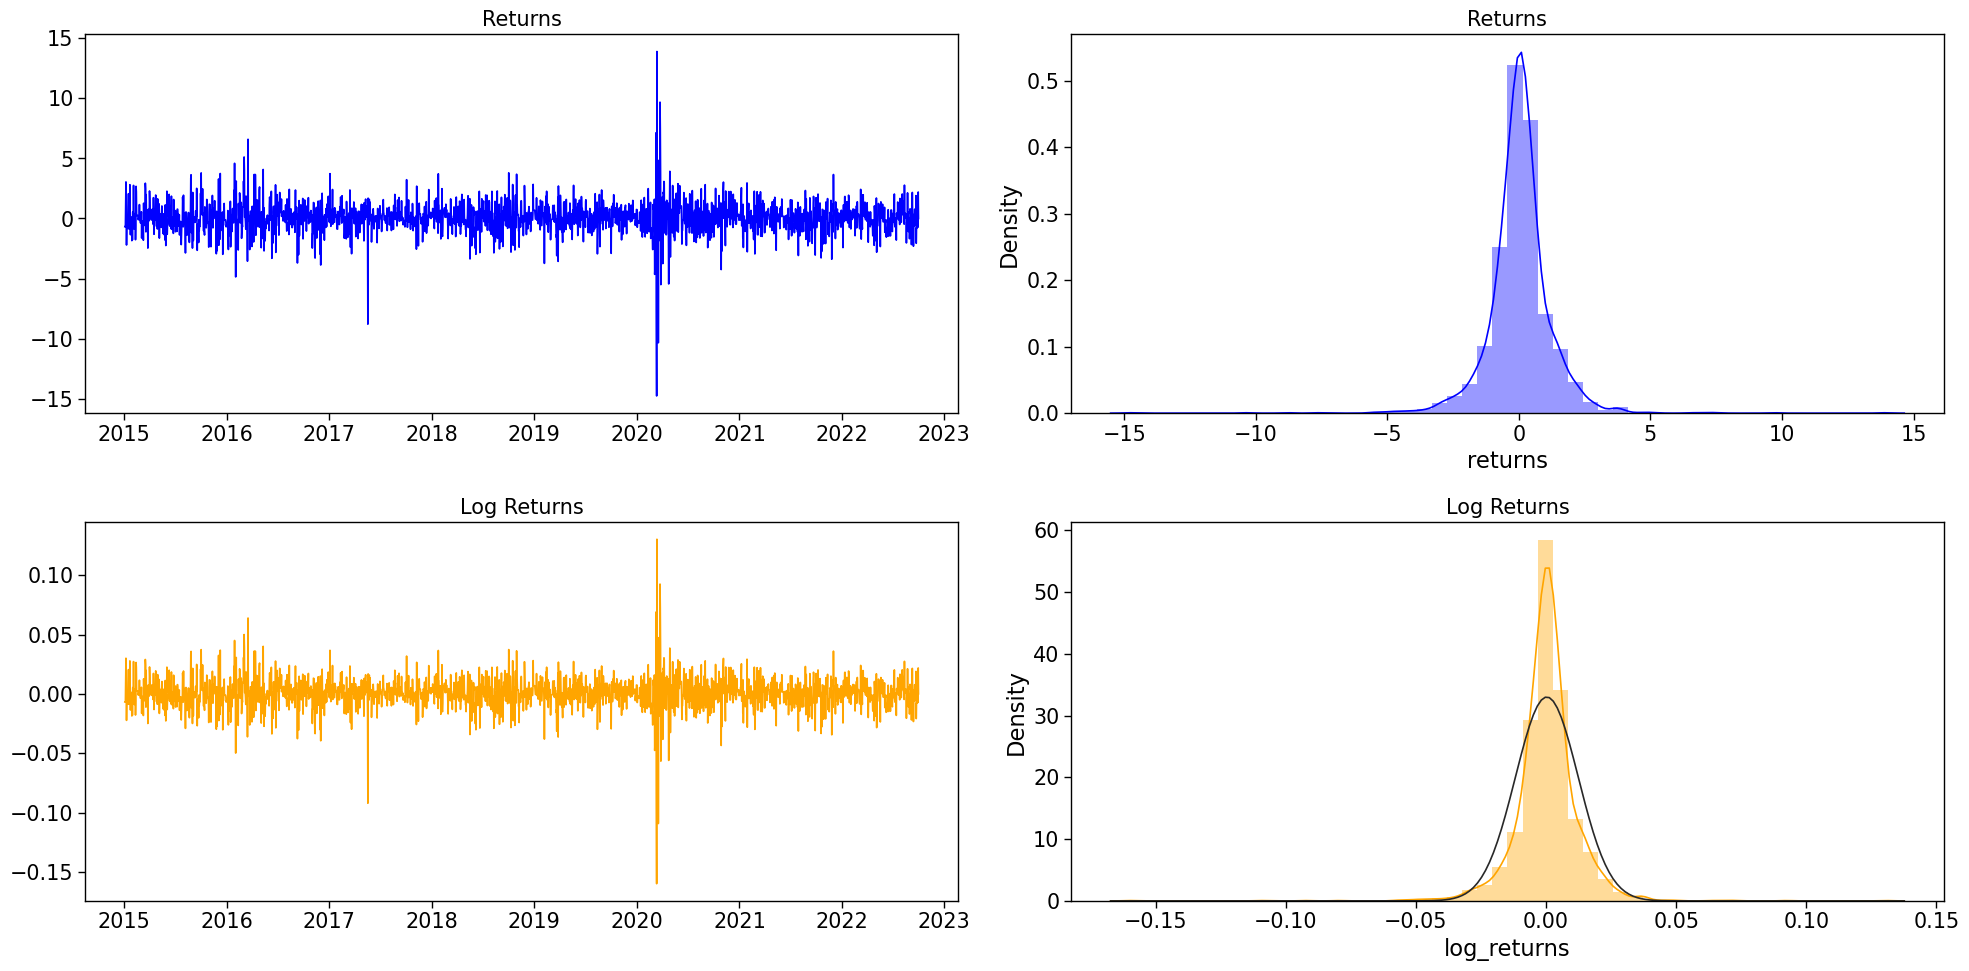

In [215]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

axes[0][0].plot(df['returns'], color='blue')
axes[0][0].set_title('Returns', fontsize=15)

sns.distplot(df['returns'],  color='blue',
             bins=50, ax=axes[0][1])
axes[0][1].set_title('Returns', fontsize=15)

axes[1][0].plot(df['log_returns'], color='orange')
axes[1][0].set_title('Log Returns', fontsize=15)

sns.distplot(df['log_returns'], norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=axes[1][1])
axes[1][1].set_title('Log Returns', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'returns.jpg'), dpi=300, bbox_inches='tight')
fig.show();

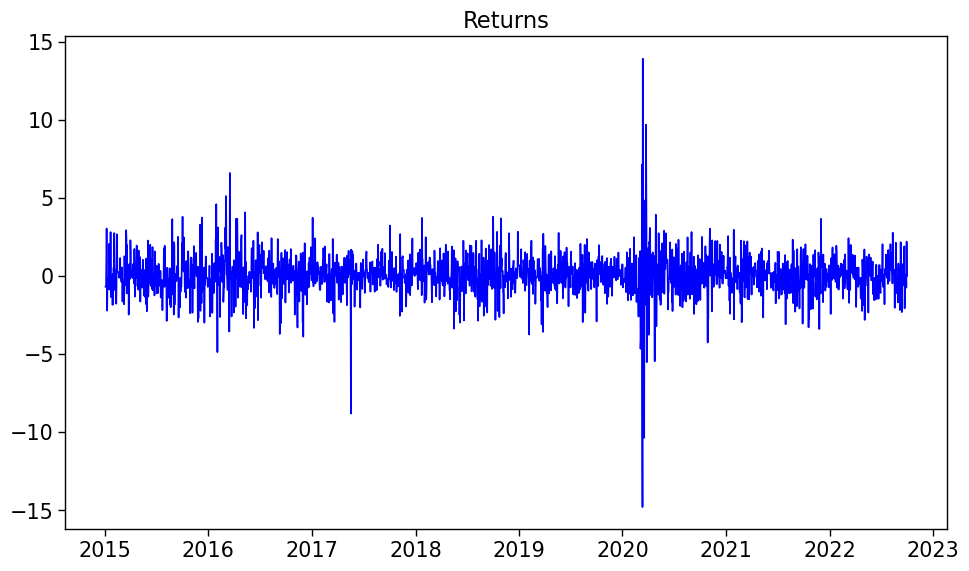

In [216]:
plt.figure(figsize=(10, 6))
plt.plot(df['returns'], color='blue')
plt.title('Returns')
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'simple-return.png'), dpi=300, bbox_inches='tight')
fig.show();

In [217]:
df['returns'].describe()

count    2829.000000
mean        0.036237
std         1.204625
min       -14.779679
25%        -0.469901
50%         0.030407
75%         0.527485
max        13.908215
Name: returns, dtype: float64

In [218]:
stats.skew(df['returns'])

-0.325288146454811

In [219]:
stats.kurtosis(df['returns'])

21.330520907659082

In [220]:
df['log_returns'].describe()

count    2829.000000
mean        0.000290
std         0.012085
min        -0.159930
25%        -0.004710
50%         0.000304
75%         0.005261
max         0.130223
Name: log_returns, dtype: float64

In [221]:
stats.skew(df['log_returns'])

-0.7567232111893324

In [222]:
stats.kurtosis(df['log_returns'])


22.964989610235733

In [223]:
shapiro(df['returns'])

ShapiroResult(statistic=0.861548900604248, pvalue=1.6815581571897805e-44)

#### **Returns/Log Returns Estacionariedade**

In [224]:
adfuller_results = adfuller(df['log_returns'])

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -11.406949493691155
p-value: 7.409536615508e-21
Critical Values:
1%: -3.4327
5%: -2.8626
10%: -2.5673


In [225]:
# RETURNS
adfuller_results = adfuller(df['returns'])

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -11.492677454403072
p-value: 4.6947619802010465e-21
Critical Values:
1%: -3.4327
5%: -2.8626
10%: -2.5673


In [226]:
kpss_results = kpss(df['returns']);
print(kpss_results)

(0.06254910989107305, 0.1, 0, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


Para o nível de significancia com alpha igual a 0.05, o `p-value` de ambos, tanto o Retorno quanto do Log Retorno são menores que o alpha, logo tem-se evidencia suficiente para rejeitar a Hipotese nula.

### Verificar Autocorrelação e Autocorrelação Parcial

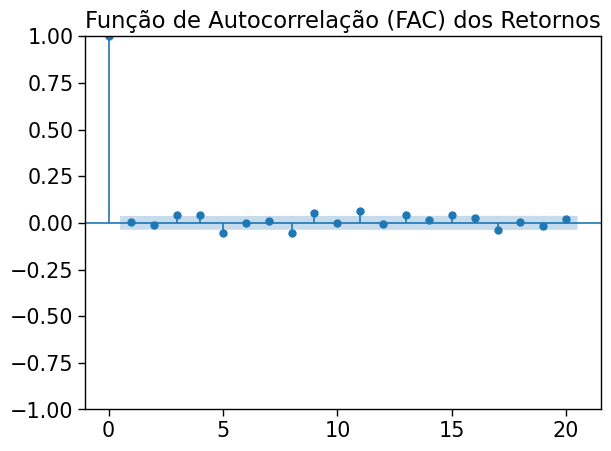

In [227]:
plot_acf(df['returns'], lags=20,  title="Função de Autocorrelação (FAC) dos Retornos");
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-return.jpg'), dpi=300, bbox_inches='tight')

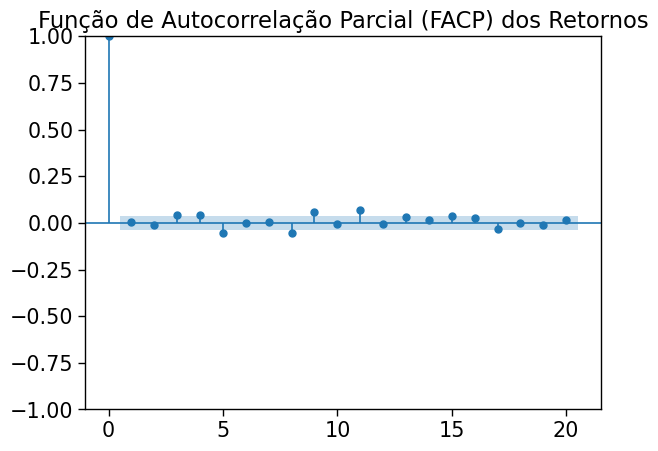

In [228]:
plot_pacf(df['returns'], lags=20, title="Função de Autocorrelação Parcial (FACP) dos Retornos");
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-return.jpg'), dpi=300, bbox_inches='tight')

In [229]:
acorr_ljungbox(df['returns'], lags=10)

,lb_stat,lb_pvalue
1,0.029279,0.864137
2,0.359329,0.835550
3,5.642824,0.130341
4,10.477610,0.033107
5,19.516110,0.001540
6,19.521077,0.003368
7,19.781130,0.006062
8,28.266918,0.000426
9,35.645327,0.000046
10,35.665335,0.000096


In [230]:
INTERVAL_WINDOW = 30
n_future = 7

df['vol_current'] = df['log_returns'].rolling(window=INTERVAL_WINDOW)\
  .apply(realized_volatility_daily)

df['vol_future'] = df['log_returns']\
    .shift(-n_future)\
    .rolling(window=INTERVAL_WINDOW)\
      .apply(realized_volatility_daily)


In [231]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,covid,returns,log_returns,vol_current,vol_future
Date,,,,,,,,,,,,
2015-01-03,49507.333333,49507.333333,47984.666667,48180.333333,3210100.0,0.0,0.0,0,-0.683680,-0.006860,NaN,NaN
2015-01-04,49009.666667,49009.666667,47624.333333,47848.666667,3538100.0,0.0,0.0,0,-0.688386,-0.006908,NaN,NaN
2015-01-05,48512.000000,48512.000000,47264.000000,47517.000000,3866100.0,0.0,0.0,0,-0.693158,-0.006956,NaN,NaN
2015-01-06,47517.000000,48061.000000,47338.000000,48001.000000,4559300.0,0.0,0.0,0,1.018583,0.010134,NaN,NaN
2015-01-07,48006.000000,49882.000000,48006.000000,49463.000000,4408800.0,0.0,0.0,0,3.045770,0.030003,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27,109122.000000,110161.000000,108120.000000,108376.000000,14517500.0,0.0,0.0,0,-0.676357,-0.006787,0.010735,NaN
2022-09-28,108377.000000,108970.000000,107914.000000,108451.000000,13540500.0,0.0,0.0,0,0.069204,0.000692,0.010736,NaN
2022-09-29,108449.000000,108449.000000,106244.000000,107664.000000,14588500.0,0.0,0.0,0,-0.725673,-0.007283,0.010351,NaN


In [232]:
df.dropna(inplace=True)

Text(0, 0.5, 'Preço Fechamento')

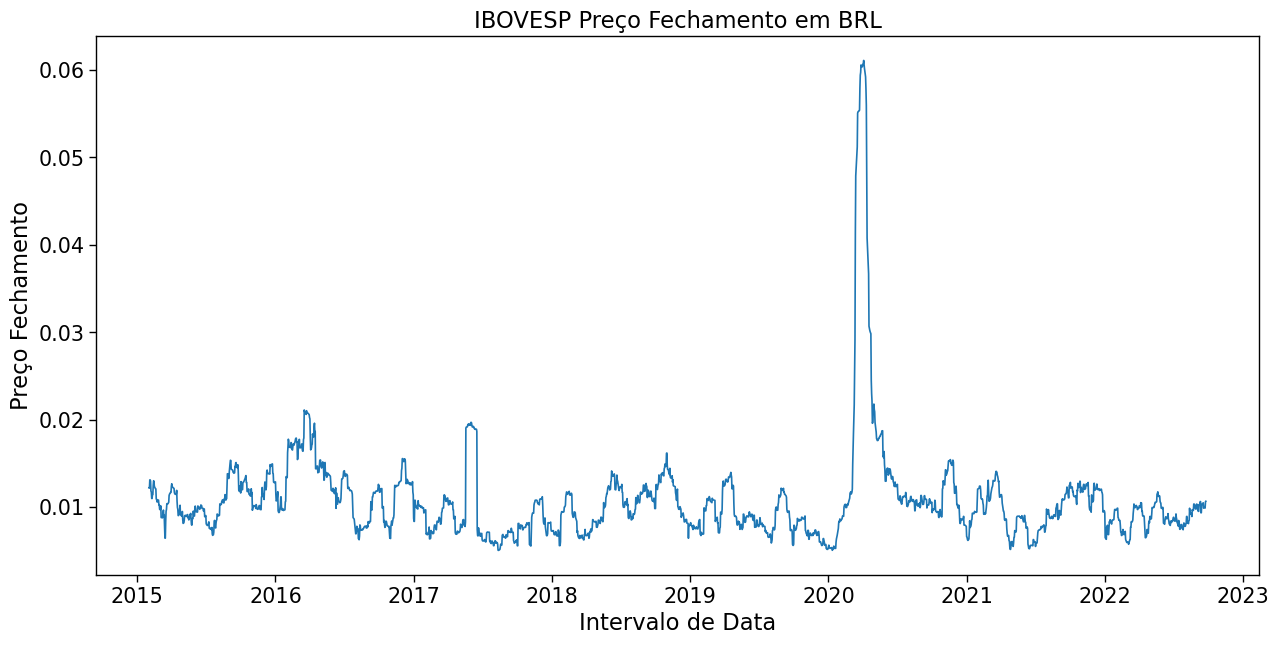

In [233]:
plt.figure(figsize=(15,7))
plt.title('IBOVESP Preço Fechamento em BRL')
plt.plot(df['vol_current'])
plt.xlabel('Intervalo de Data')
plt.ylabel('Preço Fechamento')

### Treino - Teste - Validação 

O dataset será dividido em:
- Os 30 itens finais serão utilizados para teste final.
- 1 ano inteiro para validação e ajustes do modelo
- E o restante para treinamento

In [234]:
test_size = 30
val_size = 365

# INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# PARA DIVIDIR O DATASET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [235]:
print(f'Training \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'Validation \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'Test \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

Training 	From: 2015-02-01 00:00:00 	to: 2021-08-25 00:00:00 	2398 days
Validation 	From: 2021-08-26 00:00:00 	to: 2022-08-25 00:00:00 	365 days
Test 		From: 2022-08-26 00:00:00 	to: 2022-09-24 00:00:00 	30 days


In [236]:
y_train = df['vol_future'][train_idx]
y_val = df['vol_future'][val_idx]
y_test = df['vol_future'][test_idx]

In [237]:
x_train = df['vol_current'][train_idx]
x_val = df['vol_current'][val_idx]
x_test = df['vol_current'][test_idx]

In [238]:
r_train = df['returns'][train_idx]
r_val = df['returns'][val_idx]
r_test = df['returns'][test_idx]

In [239]:
lr_train = df['log_returns'][train_idx]
lr_val = df['log_returns'][val_idx]
lr_test = df['log_returns'][test_idx]

In [240]:
covid_train = df['covid'][train_idx]
covid_val = df['covid'][val_idx]

### Normalizar os dados

In [241]:
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT REALIZED VOLATILITY IN TRAINING
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [242]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

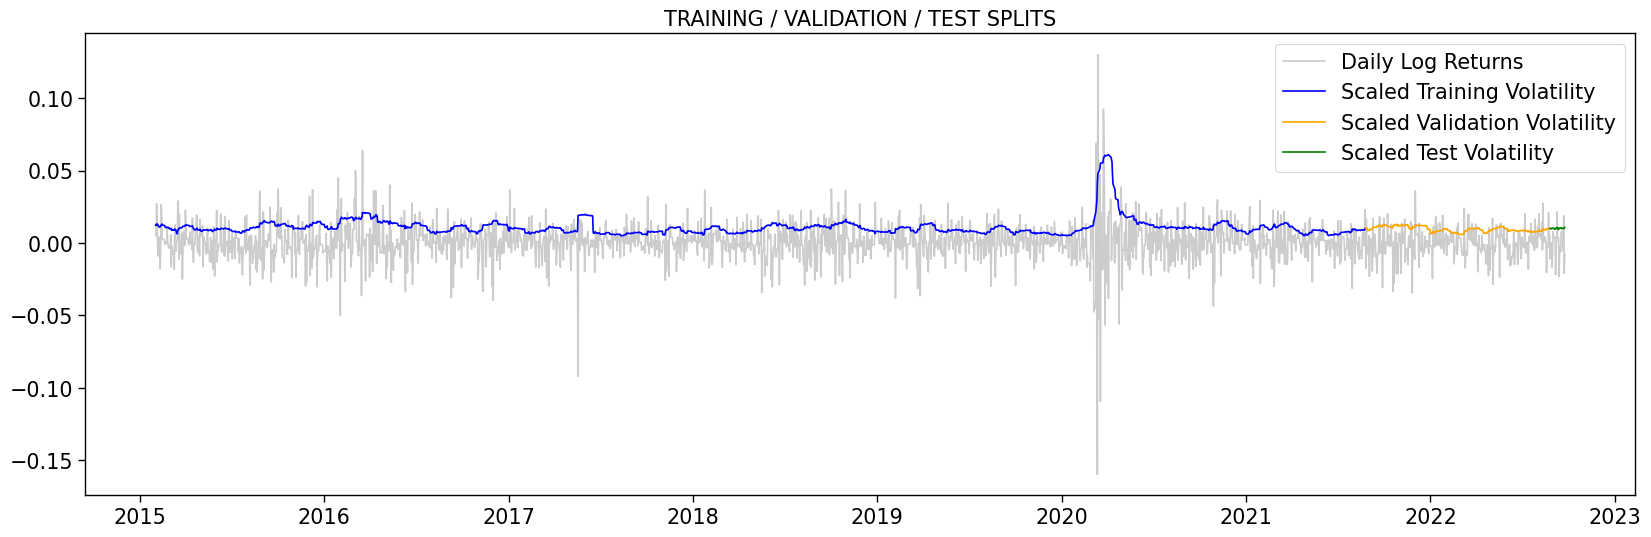

In [243]:
plt.figure(figsize=(20,6))

plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

plt.plot(x_train, color='blue', label='Scaled Training Volatility')
plt.plot(x_val, color='orange', label='Scaled Validation Volatility')
plt.plot(x_test, color='green', label='Scaled Test Volatility')

plt.plot()
plt.title(f'TRAINING / VALIDATION / TEST SPLITS', 
          fontsize=15)
plt.legend(frameon=True)
plt.savefig(os.path.join(img_dir, 'train_val_test.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [288]:
from pmdarima.arima import auto_arima

In [289]:
arma = auto_arima(
  r_train,
  d=0,
  max_q=12,
  max_p=12,
  trace=True,
  seasonal=False,
  error_action='ignore',
  suppress_warnings=True,
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=7832.213, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7839.349, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7841.304, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7841.303, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=7844.438, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7844.279, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=7833.012, Time=0.77 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=7833.366, Time=0.49 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7843.303, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=7838.389, Time=0.35 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=7838.214, Time=0.27 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=7833.135, Time=1.60 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7830.620, Time=2.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=7842.875, Time=1.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept

In [290]:
resid_arma = arma.resid()

In [291]:
acorr_ljungbox(resid_arma)

,lb_stat,lb_pvalue
1,0.014336,0.904693
2,3.314334,0.190678
3,3.721738,0.293121
4,8.212758,0.084088
5,10.726073,0.057090
6,11.077759,0.086003
7,11.077767,0.135263
8,18.076643,0.020659
9,23.213483,0.005734
10,24.824201,0.005689


In [292]:
het_arch(resid_arma, nlags=10 )

(865.0730142478528,
 2.087791361291152e-179,
 135.0214799596309,
 9.602419839924195e-224)

In [293]:
gm_resid_11 = arch_model(resid_arma, p=1, q=1)
result_resid_11 = gm_resid_11.fit(disp='off')

In [294]:
result_resid_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3544.38
Distribution:                  Normal   AIC:                           7096.76
Method:            Maximum Likelihood   BIC:                           7119.89
                                        No. Observations:                 2398
Date:                Wed, Mar 22 2023   Df Residuals:                     2397
Time:                        00:43:49   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0267  2.191e-02      1.218      0.223 [-1.626e-02,6.964e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0724  4.825e-02      1.500      0.134 [-2.219e-02,  0.167]
alpha[1]       0.0835  3.227e-02      2.587  9.681e-03  [2.023e-02,  0.147]
beta[1]        0.8585  6.655e-02     12.899  4.535e-38    [  0.728,  0.989]
===========================================================================

Covariance estimator: robust
"""

In [295]:
log_garch(result_resid_11, "ARMA-GARCH (1,1) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"GARCH (1,1) - Normal",7083.339335,7106.468897,0.198837,0.000010,0.000120,7.336734e-28
"GARCH (1,1) - Student",6699.802292,6728.714244,0.197900,0.000010,0.000102,0.000000e+00
"GARCH (1,2) - Normal",7072.481031,7101.392983,0.198477,0.000007,0.000079,1.384295e-27
"GARCH (2,1) - Normal",7085.339335,7114.251287,0.198837,0.000010,0.000120,7.332821e-28
"GARCH (2,2) - Normal",7074.481031,7109.175373,0.198475,0.000007,0.000079,1.384050e-27
"ARMA-GARCH (1,1) - Normal",7096.755590,7119.885151,0.017329,0.000023,0.000218,1.619515e-27


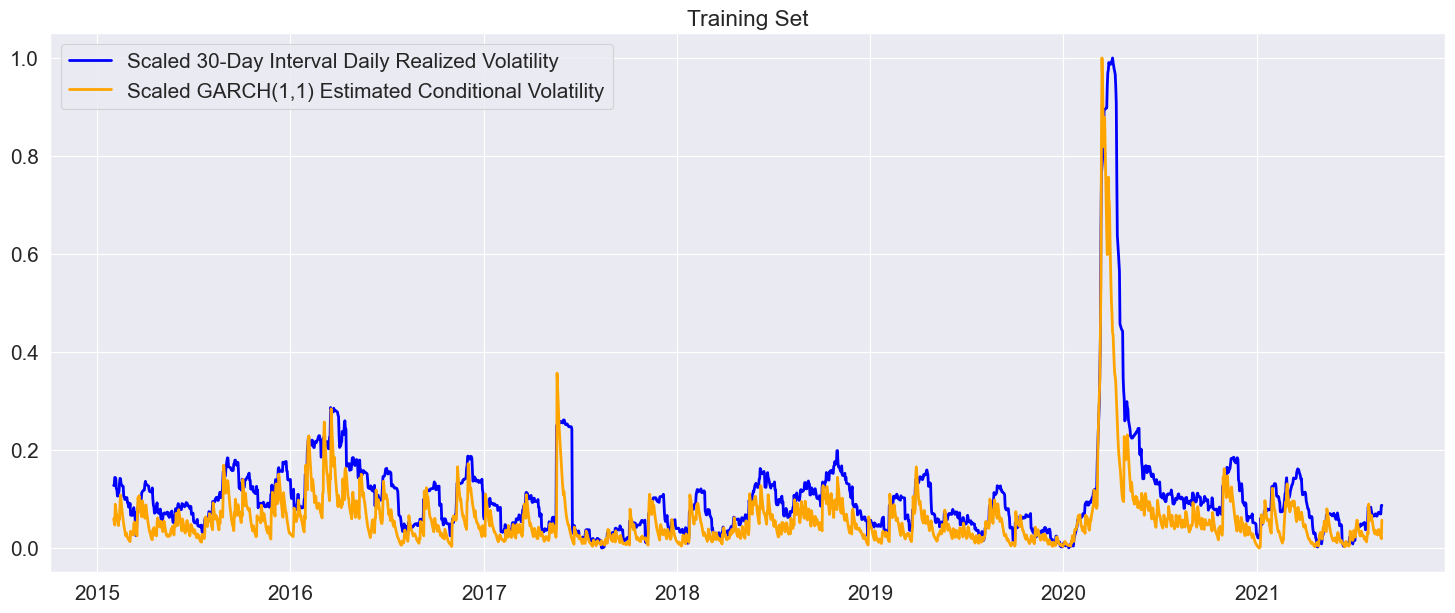

In [297]:
scaler_garch_resid_11, scaled_cond_vol_resid_11 = scale_tf_cond_vol(result_resid_11)
viz_cond_vol(scaled_cond_vol_resid_11, 'GARCH(1,1)')

### GARCH MODELS

some Util links
- https://www.oreilly.com/library/view/machine-learning-for/9781492085249/ch04.html
- https://users.metu.edu.tr/home402/ozancan/wwwhome/ARCHGARCHTutorial.html
- https://bibliotecadigital.fgv.br/dspace/bitstream/handle/10438/10014/TD%20313%20-%20CEQEF%2003%20-%20Marcos%20Vinicio%20Wink%20Junior%20e%20%20Pedro%20Valls.pdf?sequence=1
- https://repositorio.ufc.br/bitstream/riufc/39729/1/2018_tcc_wlalves.pdf
- file:///C:/Users/Gabriel/Downloads/paulo%20thomaz.pdf

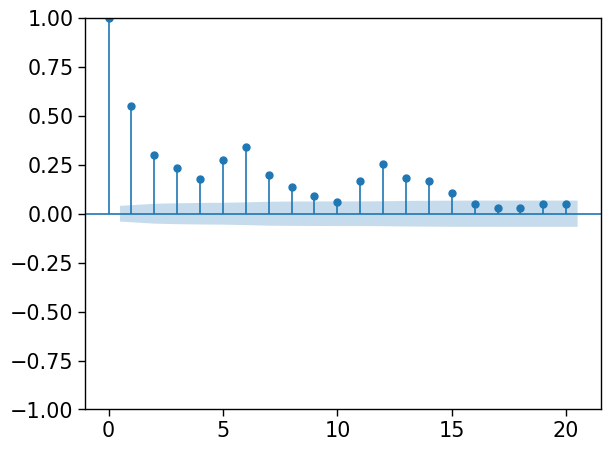

In [278]:
plot_acf(r_train**2,lags=20, title="");
        #   title='Função de Autocorrelação (FAC) do quadrado dos Retornos');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-return-squared.jpg'), dpi=300, bbox_inches='tight')

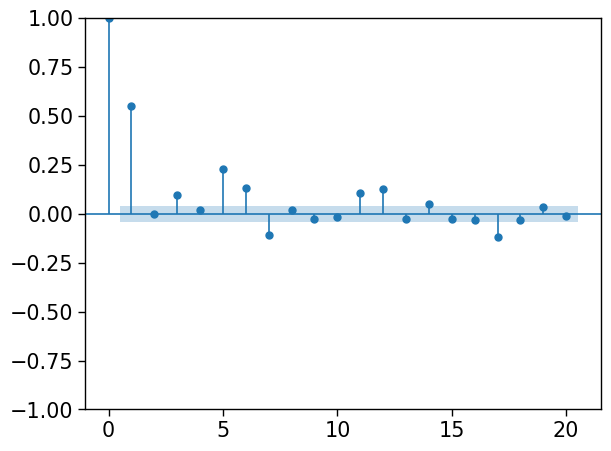

In [279]:
plot_pacf(r_train**2, lags=20, title="")
        #   title='Função de Autocorrelação Parcial (FACP) do quadrado dos Retornos\n(Treinamento)');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-return-squared.jpg'), dpi=300, bbox_inches='tight')

Verifica-se pelo quadrado dos retornos que o modelo ARCH é adaquado

### GARCH

In [280]:
from arch import arch_model

In [281]:
gm_22 = arch_model(r_train, p=2, q=2)
result_22 = gm_22.fit(disp='off')
gm_11 = arch_model(r_train, p=1, q=1)
result_11 = gm_11.fit(disp='off')
gm_21 = arch_model(r_train, p=2, q=1)
result_21 = gm_21.fit(disp='off')
gm_12 = arch_model(r_train, p=1, q=2)
result_12 = gm_12.fit(disp='off')

gm_10 = arch_model(r_train, p=1, q=0)
result_10 = gm_10.fit(disp='off')

In [282]:
result_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3537.67
Distribution:                  Normal   AIC:                           7083.34
Method:            Maximum Likelihood   BIC:                           7106.47
                                        No. Observations:                 2398
Date:                Wed, Mar 22 2023   Df Residuals:                     2397
Time:                        00:29:09   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0735  2.178e-02      3.373  7.435e-04 [3.077e-02,  0.116]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0711  4.298e-02      1.653  9.829e-02 [-1.319e-02,  0.155]
alpha[1]       0.0836  2.984e-02      2.801  5.089e-03  [2.510e-02,  0.142]
beta[1]        0.8593  5.961e-02     14.416  4.130e-47    [  0.742,  0.976]
===========================================================================

Covariance estimator: robust
"""

In [284]:
log_garch(result_11, "GARCH (1,1) - Normal")
log_garch(result_12, "GARCH (1,2) - Normal")
log_garch(result_21, "GARCH (2,1) - Normal")
log_garch(result_22, "GARCH (2,2) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"GARCH (1,1) - Normal",7083.339335,7106.468897,0.198837,0.000010,0.000120,7.336734e-28
"GARCH (1,1) - Student",6699.802292,6728.714244,0.197900,0.000010,0.000102,0.000000e+00
"GARCH (1,2) - Normal",7072.481031,7101.392983,0.198477,0.000007,0.000079,1.384295e-27
"GARCH (2,1) - Normal",7085.339335,7114.251287,0.198837,0.000010,0.000120,7.332821e-28
"GARCH (2,2) - Normal",7074.481031,7109.175373,0.198475,0.000007,0.000079,1.384050e-27


Utilizando nivel de significande de 0.05, nenhum dos coefieficientes para os modelos (1,2), (2,1), (2,2) parecem ser estatisticamente significante, já que o os seus p-values `P > |t|` são todos maiores que 0.05. diferente do GARCH (1,1)

É possivel verificar que que pelo test `Shapiro Wilk (SW)`, `p-value` é menor que 0.05, portanto é rejeita-se a hipotese nula e assim, temos evidencia suficiente para dizer que não segue uma distribuição normal, o que é comum para series financeiras, porém o modelo garch permite setar a distribuição como T Student , 

In [285]:
gm_student_11 = arch_model(r_train, p=1, q=1, dist="StudentsT")
result_student_11 = gm_student_11.fit(disp='off')
gm_student_22 = arch_model(r_train, p=2, q=2, dist="StudentsT")
result_student_22 = gm_student_22.fit(disp='off')
gm_student_12 = arch_model(r_train, p=1, q=2, dist="StudentsT")
result_student_12 = gm_student_12.fit(disp='off')
gm_student_21 = arch_model(r_train, p=2, q=1, dist="StudentsT")
result_student_21 = gm_student_21.fit(disp='off')

In [286]:
result_student_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3344.90
Distribution:      Standardized Student's t   AIC:                           6699.80
Method:                  Maximum Likelihood   BIC:                           6728.71
                                              No. Observations:                 2398
Date:                      Wed, Mar 22 2023   Df Residuals:                     2397
Time:                              00:35:10   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0591  1.581e-02      3.738  1.854e-04 [2.812e-02,9.010e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0623  3.365e-02      1.850  6.425e-02 [-3.684e-03,  0.128]
alpha[1]       0.0912  3.450e-02      2.645  8.180e-03  [2.362e-02,  0.159]
beta[1]        0.8966  4.156e-02     21.574 3.165e-103    [  0.815,  0.978]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.8341      0.187     15.173  5.376e-52 [  2.468,  3.200]
========================================================================

Covariance estimator: robust
"""

In [299]:
log_garch(result_student_11, "GARCH (1,1) - Student", False)
log_garch(result_student_12, "GARCH (1,2) - Student", False)
log_garch(result_student_21, "GARCH (2,1) - Student", False)
log_garch(result_student_22, "GARCH (2,2) - Student", False)

,AIC,BIC,LB,LB(r²),ARCH,SW
"GARCH (1,1) - Normal",7083.339335,7106.468897,0.198837,0.000010,0.000120,7.336734e-28
"GARCH (1,1) - Student",6699.802292,6728.714244,0.197900,0.000010,0.000102,0.000000e+00
"GARCH (1,2) - Normal",7072.481031,7101.392983,0.198477,0.000007,0.000079,1.384295e-27
"GARCH (2,1) - Normal",7085.339335,7114.251287,0.198837,0.000010,0.000120,7.332821e-28
"GARCH (2,2) - Normal",7074.481031,7109.175373,0.198475,0.000007,0.000079,1.384050e-27
"ARMA-GARCH (1,1) - Normal",7096.755590,7119.885151,0.017329,0.000023,0.000218,1.619515e-27
"GARCH (1,2) - Student",6691.922831,6726.617173,0.196254,0.000009,0.000085,0.000000e+00
"GARCH (2,1) - Student",6701.802293,6736.496635,0.197907,0.000010,0.000102,0.000000e+00
"GARCH (2,2) - Student",6693.922832,6734.399564,0.196243,0.000009,0.000084,0.000000e+00


In [253]:
scaler_garch_11, scaled_cond_vol_11 = scale_tf_cond_vol(result_11)
viz_cond_vol(scaled_cond_vol_11, 'GARCH(1,1)')

### Expanding Window Forecasting

Será dada a previsão para os próximo dias futuros `n_future = 14` e assim deve-se reajustar o modelo para cada passo no tempo.


In [255]:
def expading_window_forecast_garch(arch_model):
    size = len(val_idx)
    rolling_forecasts = []
    idx = df.index
    # Set de validação
    for i in range(0, size, 1):
    # Pegar os valores anteriores a esse step
        idx = val_idx[i]
        train = df.returns[:idx]
        # treinar o modelo até esse step
        model = arch_model(train)
        model_fit = model.fit(disp='off')
        # fazer a predição com n_future 
        values = model_fit.forecast(horizon=1, 
                             reindex=False).variance.iloc[0]
        for value in values:
            rolling_forecasts.append(value)
    values_forecast = []
    for i in range(size):
        values_forecast.append(rolling_forecasts[i]**.5)
    return pd.Series(values_forecast, index=val_idx)

In [256]:
gm_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, vol='GARCH', p=1, q=1) )

In [257]:
gm_11_preds_scaled = transform_volatility_to_scaler(scaler_garch_11, gm_11_preds)

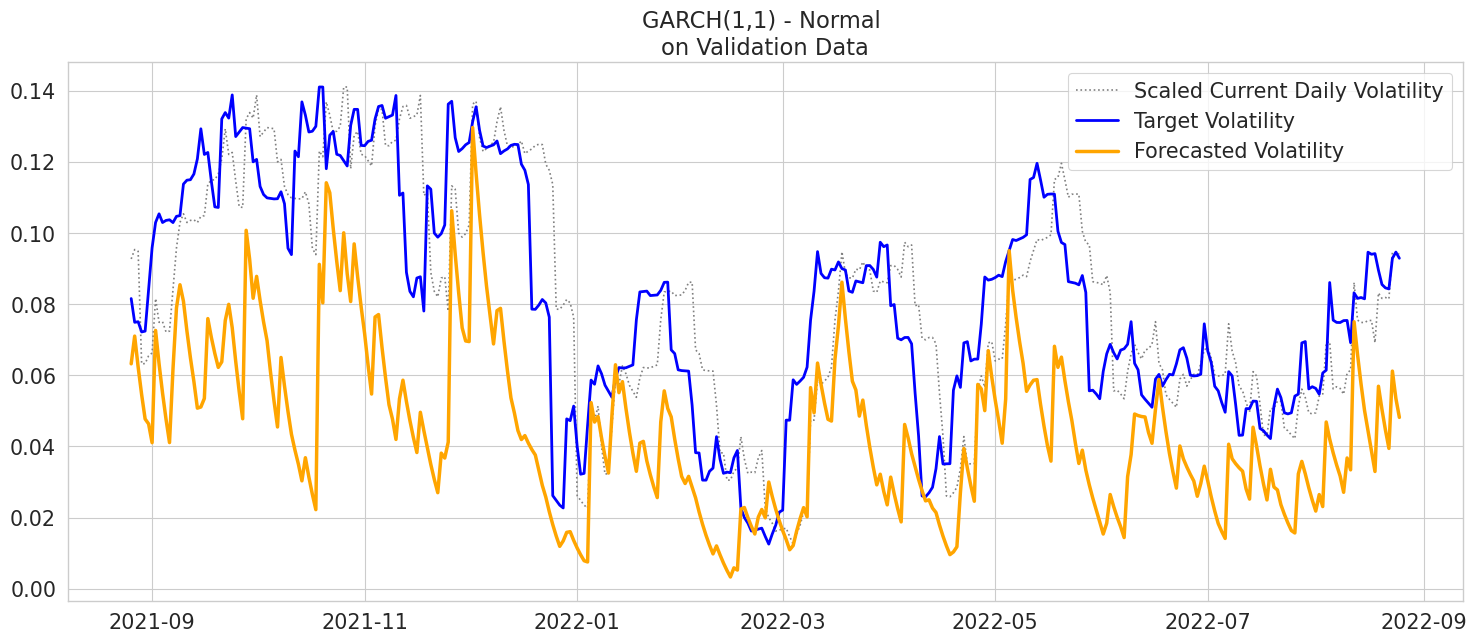

In [258]:
viz_model(y_val_scaled, gm_11_preds_scaled, 'GARCH(1,1) - Normal')

In [259]:
log_perf(y_val_scaled, gm_11_preds_scaled,'GARCH(1,1) - Normal')

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001799,0.495983,0.042414,0.454116


In [260]:
gm_student_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, vol='GARCH', p=1, q=1, dist="StudentsT") )
scaler_garch_student_11, scaled_cond_vol_student_11 = scale_tf_cond_vol(result_student_11)
gm_student_11_preds_scaled = transform_volatility_to_scaler(scaler_garch_student_11, gm_student_11_preds)
log_perf(y_val_scaled, gm_student_11_preds_scaled,'GARCH(1,1) - Student')

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001799,0.495983,0.042414,0.454116
"GARCH(1,1) - Student",0.001418,0.450473,0.037654,0.405811


### Garch Model with asymmetric shock response

In [72]:
gjr_gm_11 = arch_model(r_train, p=1, q=1, o=1, vol='GARCH')
result_gjr_gm_11 = gjr_gm_11.fit(disp='off')
gjr_gm_22 = arch_model(r_train, p=2, q=2, o=1, vol='GARCH')
result_gjr_gm_22 = gjr_gm_22.fit(disp='off')
gjr_gm_21 = arch_model(r_train, p=2, q=1, o=1, vol='GARCH')
result_gjr_gm_21 = gjr_gm_21.fit(disp='off')
gjr_gm_12 = arch_model(r_train, p=1, q=2, o=1, vol='GARCH')
result_gjr_gm_12 = gjr_gm_12.fit(disp='off')

In [73]:
result_gjr_gm_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3528.24
Distribution:                  Normal   AIC:                           7066.47
Method:            Maximum Likelihood   BIC:                           7095.38
                                        No. Observations:                 2398
Date:                Tue, Mar 21 2023   Df Residuals:                     2397
Time:                        14:32:32   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0619  2.137e-02      2.897  3.770e-03 [2.002e-02,  0.104]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0645  3.997e-02      1.614      0.107   [-1.385e-02,  0.143]
alpha[1]       0.0402  2.239e-02      1.793  7.293e-02 [-3.732e-03,8.404e-02]
gamma[1]       0.0792  4.001e-02      1.979  4.784e-02    [7.515e-04,  0.158]
beta[1]        0.8688  5.841e-02     14.874  4.886e-50      [  0.754,  0.983]
=============================================================================

Covariance estimator: robust
"""

In [74]:
log_garch(result_gjr_gm_11, "GJR-GARCH (1,1) - Normal")
log_garch(result_gjr_gm_12, "GJR-GARCH (1,2) - Normal")
log_garch(result_gjr_gm_21, "GJR-GARCH (2,1) - Normal")
log_garch(result_gjr_gm_22, "GJR-GARCH (2,2) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"GARCH (1,1) - Normal",7083.339335,7106.468897,0.198837,0.000010,0.000120,7.336734e-28
"GARCH (1,1) - Student",6699.802292,6728.714244,0.197900,0.000010,0.000102,0.000000e+00
"GJR-GARCH (1,1) - Normal",7066.472918,7095.384869,0.150870,0.000005,0.000070,6.353463e-28


In [75]:
gjr_gm_student_11 = arch_model(r_train, p=1, q=1, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_11 = gjr_gm_student_11.fit(disp='off')
gjr_gm_student_22 = arch_model(r_train, p=2, q=2, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_22 = gjr_gm_student_22.fit(disp='off')
gjr_gm_student_21 = arch_model(r_train, p=2, q=1, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_21 = gjr_gm_student_21.fit(disp='off')
gjr_gm_student_12 = arch_model(r_train, p=1, q=2, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_12 = gjr_gm_student_12.fit(disp='off')

In [76]:
result_gjr_gm_student_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3332.50
Distribution:      Standardized Student's t   AIC:                           6677.00
Method:                  Maximum Likelihood   BIC:                           6711.69
                                              No. Observations:                 2398
Date:                      Tue, Mar 21 2023   Df Residuals:                     2397
Time:                              14:32:33   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0543  1.553e-02      3.500  4.648e-04 [2.391e-02,8.477e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0672  2.531e-02      2.654  7.950e-03    [1.757e-02,  0.117]
alpha[1]       0.0241  1.926e-02      1.250      0.211 [-1.367e-02,6.184e-02]
gamma[1]       0.1572  5.251e-02      2.993  2.761e-03    [5.426e-02,  0.260]
beta[1]        0.8872  3.093e-02     28.686 5.725e-181      [  0.827,  0.948]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.8519      0.187     15.286  9.544e-53 [  2.486,  3.218]
========================================================================

Covariance estimator: robust
"""

In [300]:
log_garch(result_gjr_gm_student_11, "GJR-GARCH (1,1) - Student")
log_garch(result_gjr_gm_student_12, "GJR-GARCH (1,2) - Student")
log_garch(result_gjr_gm_student_21, "GJR-GARCH (2,1) - Student")
log_garch(result_gjr_gm_student_22, "GJR-GARCH (2,2) - Student")

,AIC,BIC,LB,LB(r²),ARCH,SW
"GARCH (1,1) - Normal",7083.339335,7106.468897,0.198837,1.011567e-05,0.000120,7.336734e-28
"GARCH (1,1) - Student",6699.802292,6728.714244,0.197900,9.581920e-06,0.000102,0.000000e+00
"GARCH (1,2) - Normal",7072.481031,7101.392983,0.198477,7.180785e-06,0.000079,1.384295e-27
"GARCH (2,1) - Normal",7085.339335,7114.251287,0.198837,1.011661e-05,0.000120,7.332821e-28
"GARCH (2,2) - Normal",7074.481031,7109.175373,0.198475,7.180862e-06,0.000079,1.384050e-27
"ARMA-GARCH (1,1) - Normal",7096.755590,7119.885151,0.017329,2.344445e-05,0.000218,1.619515e-27
"GARCH (1,2) - Student",6691.922831,6726.617173,0.196254,8.852751e-06,0.000085,0.000000e+00
"GARCH (2,1) - Student",6701.802293,6736.496635,0.197907,9.581531e-06,0.000102,0.000000e+00
"GARCH (2,2) - Student",6693.922832,6734.399564,0.196243,8.849950e-06,0.000084,0.000000e+00
"GJR-GARCH (1,1) - Student",6676.995061,6711.689403,0.105835,5.104296e-06,0.000068,2.340953e-28


### TARCH

In [78]:

np.random.seed(seed)
t_gm_11 = arch_model(r_train, p=1, o=1, q=1, power=1.0, dist='normal')
result_t_gm_11 = t_gm_11.fit(disp='off')
t_gm_22 = arch_model(r_train, p=2, o=1, q=2, power=1.0, dist='normal')
result_t_gm_22 = t_gm_22.fit(disp='off')
t_gm_21 = arch_model(r_train, p=2, o=1, q=1, power=1.0, dist='normal')
result_t_gm_21 = t_gm_21.fit(disp='off')
t_gm_12 = arch_model(r_train, p=1, o=1, q=2, power=1.0, dist='normal')
result_t_gm_12 = t_gm_12.fit(disp='off')

In [79]:
result_t_gm_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Constant Mean - TARCH/ZARCH Model Results                   
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -3531.70
Distribution:                  Normal   AIC:                           7073.40
Method:            Maximum Likelihood   BIC:                           7102.31
                                        No. Observations:                 2398
Date:                Tue, Mar 21 2023   Df Residuals:                     2397
Time:                        14:32:34   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0450  2.571e-02      1.751  7.992e-02 [-5.367e-03,9.540e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.6864  5.582e-02     12.297  9.355e-35    [  0.577,  0.796]
alpha[1]       0.3476  4.956e-02      7.014  2.317e-12    [  0.250,  0.445]
gamma[1]       0.1032  7.050e-02      1.463      0.143 [-3.501e-02,  0.241]
beta[1]        0.0965  5.600e-02      1.723  8.490e-02 [-1.327e-02,  0.206]
===========================================================================

Covariance estimator: robust
"""

In [311]:
log_garch(result_t_gm_11, "TARCH (1,1) - Normal")
log_garch(result_t_gm_12, "TARCH (1,2) - Normal")
log_garch(result_t_gm_21, "TARCH (2,1) - Normal")
log_garch(result_t_gm_22, "TARCH (2,2) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"TARCH (1,1) - Normal",7073.401741,7102.313693,0.126231,2.592219e-14,8.233783e-15,3.251028e-29
"TARCH (1,2) - Normal",7033.369310,7068.063652,0.134755,3.013188e-06,3.150386e-05,5.347352e-28
"TARCH (2,1) - Normal",7054.354547,7089.048889,0.140367,2.663855e-05,1.937251e-04,1.139883e-28
"TARCH (2,2) - Normal",7035.369307,7075.846039,0.134766,3.013038e-06,3.150543e-05,5.344605e-28


In [81]:
t_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, p=1, o=1, q=1, power=1.0) )
scaler_tarch_11, scaled_tarch_cond_vol_11 = scale_tf_cond_vol(result_student_11)
t_11_preds_scaled = transform_volatility_to_scaler(scaler_tarch_11, t_11_preds)

In [308]:
np.random.seed(seed)
t_gm_student_11 = arch_model(r_train, p=1, o=1, q=1, power=1.0, dist='StudentsT')
result_t_gm_student_11 = t_gm_student_11.fit(disp='off')
t_gm_student_22 = arch_model(r_train, p=2, o=1, q=2, power=1.0, dist='StudentsT')
result_t_gm_student_22 = t_gm_student_22.fit(disp='off')
t_gm_student_21 = arch_model(r_train, p=2, o=1, q=1, power=1.0, dist='StudentsT')
result_t_gm_student_21 = t_gm_student_21.fit(disp='off')
t_gm_student_12 = arch_model(r_train, p=1, o=1, q=2, power=1.0, dist='StudentsT')
result_t_gm_student_12 = t_gm_student_12.fit(disp='off')

In [303]:
result_t_gm_student_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - TARCH/ZARCH Model Results                      
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -3285.71
Distribution:      Standardized Student's t   AIC:                           6583.43
Method:                  Maximum Likelihood   BIC:                           6618.12
                                              No. Observations:                 2398
Date:                      Wed, Mar 22 2023   Df Residuals:                     2397
Time:                              01:13:46   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0545  1.986e-02      2.742  6.101e-03 [1.554e-02,9.340e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.8130  8.504e-02      9.561  1.170e-21      [  0.646,  0.980]
alpha[1]       0.8385      0.163      5.151  2.584e-07      [  0.519,  1.157]
gamma[1]       0.1559  9.135e-02      1.707  8.785e-02   [-2.312e-02,  0.335]
beta[1]        0.0334  2.854e-02      1.168      0.243 [-2.260e-02,8.930e-02]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.4530      0.147     16.701  1.279e-62 [  2.165,  2.741]
========================================================================

Covariance estimator: robust
"""

In [312]:
log_garch(result_t_gm_student_11, "TARCH (1,1) - Student", False)
log_garch(result_t_gm_student_12, "TARCH (1,2) - Student", False)
log_garch(result_t_gm_student_21, "TARCH (2,1) - Student", False)
log_garch(result_t_gm_student_11, "TARCH (2,2) - Student", False)

,AIC,BIC,LB,LB(r²),ARCH,SW
"TARCH (1,1) - Normal",7073.401741,7102.313693,0.126231,2.592219e-14,8.233783e-15,3.251028e-29
"TARCH (1,2) - Normal",7033.369310,7068.063652,0.134755,3.013188e-06,3.150386e-05,5.347352e-28
"TARCH (2,1) - Normal",7054.354547,7089.048889,0.140367,2.663855e-05,1.937251e-04,1.139883e-28
"TARCH (2,2) - Normal",7035.369307,7075.846039,0.134766,3.013038e-06,3.150543e-05,5.344605e-28
"TARCH (1,1) - Student",6583.427644,6618.121986,0.220978,2.196741e-11,1.589225e-12,NaN
"TARCH (1,2) - Student",6640.468686,6680.945419,0.095773,3.553227e-06,3.759819e-05,NaN
"TARCH (2,1) - Student",6649.978574,6690.455306,0.079684,5.430952e-05,3.475169e-04,NaN
"TARCH (2,2) - Student",6583.427644,6618.121986,0.220978,2.196741e-11,1.589225e-12,NaN


In [82]:
e_gm_11 = arch_model(r_train, vol='EGARCH', p=1, o=1, q=1, power=1.0, dist='normal')
result_e_gm_11 = e_gm_11.fit(disp='off')
print(result_e_gm_11.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3522.62
Distribution:                  Normal   AIC:                           7055.23
Method:            Maximum Likelihood   BIC:                           7084.15
                                        No. Observations:                 2398
Date:                Tue, Mar 21 2023   Df Residuals:                     2397
Time:                        14:32:49   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0567  4.104e-03     13.808  2.279e-43 [4.

In [83]:
t_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, p=1, o=1, q=1, power=1.0) )
scaler_tarch_11, scaled_tarch_cond_vol_11 = scale_tf_cond_vol(result_student_11)
t_11_preds_scaled = transform_volatility_to_scaler(scaler_tarch_11, t_11_preds)

In [84]:

np.random.seed(seed)

t_gm_12 = arch_model(r_train, p=1, o=1, q=2, power=1.0,
                  dist='skewt')
result_gm_12 = t_gm_12.fit(disp='off')
print(result_gm_12.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -3312.85
Distribution:      Standardized Skew Student's t   AIC:                           6641.70
Method:                       Maximum Likelihood   BIC:                           6687.96
                                                   No. Observations:                 2398
Date:                           Tue, Mar 21 2023   Df Residuals:                     2397
Time:                                   14:33:04   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [85]:

np.random.seed(seed)

t_gm_21 = arch_model(r_train, p=2, o=1, q=1, power=1.0,
                  dist='skewt')
result_gm_21 = t_gm_21.fit(disp='off')
print(result_gm_21.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -3317.65
Distribution:      Standardized Skew Student's t   AIC:                           6651.31
Method:                       Maximum Likelihood   BIC:                           6697.57
                                                   No. Observations:                 2398
Date:                           Tue, Mar 21 2023   Df Residuals:                     2397
Time:                                   14:33:04   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [86]:

np.random.seed(seed)

t_gm_12 = arch_model(r_train, p=2, o=1, q=2, power=1.0,
                  dist='skewt')
result_gm_12 = t_gm_12.fit(disp='off')
print(result_gm_12.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -3312.85
Distribution:      Standardized Skew Student's t   AIC:                           6643.70
Method:                       Maximum Likelihood   BIC:                           6695.74
                                                   No. Observations:                 2398
Date:                           Tue, Mar 21 2023   Df Residuals:                     2397
Time:                                   14:33:05   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [87]:

np.random.seed(seed)

t_gm_student_11 = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='t')
result_gm_student_11 = t_gm_student_11.fit(disp='off')
print(result_gm_student_11.summary())

                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -3285.71
Distribution:      Standardized Student's t   AIC:                           6583.43
Method:                  Maximum Likelihood   BIC:                           6618.12
                                              No. Observations:                 2398
Date:                      Tue, Mar 21 2023   Df Residuals:                     2397
Time:                              14:33:05   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

### SALVAR Modelos

In [88]:
modelToSave = arch_model(df['returns'], vol='GARCH', p=1, q=1, dist="StudentsT").fit(disp='off')
scaler_garch_to_save, scaled_cond_vol_to_save = scale_tf_cond_vol(modelToSave)
df['garch11_student'] = scaled_cond_vol_to_save

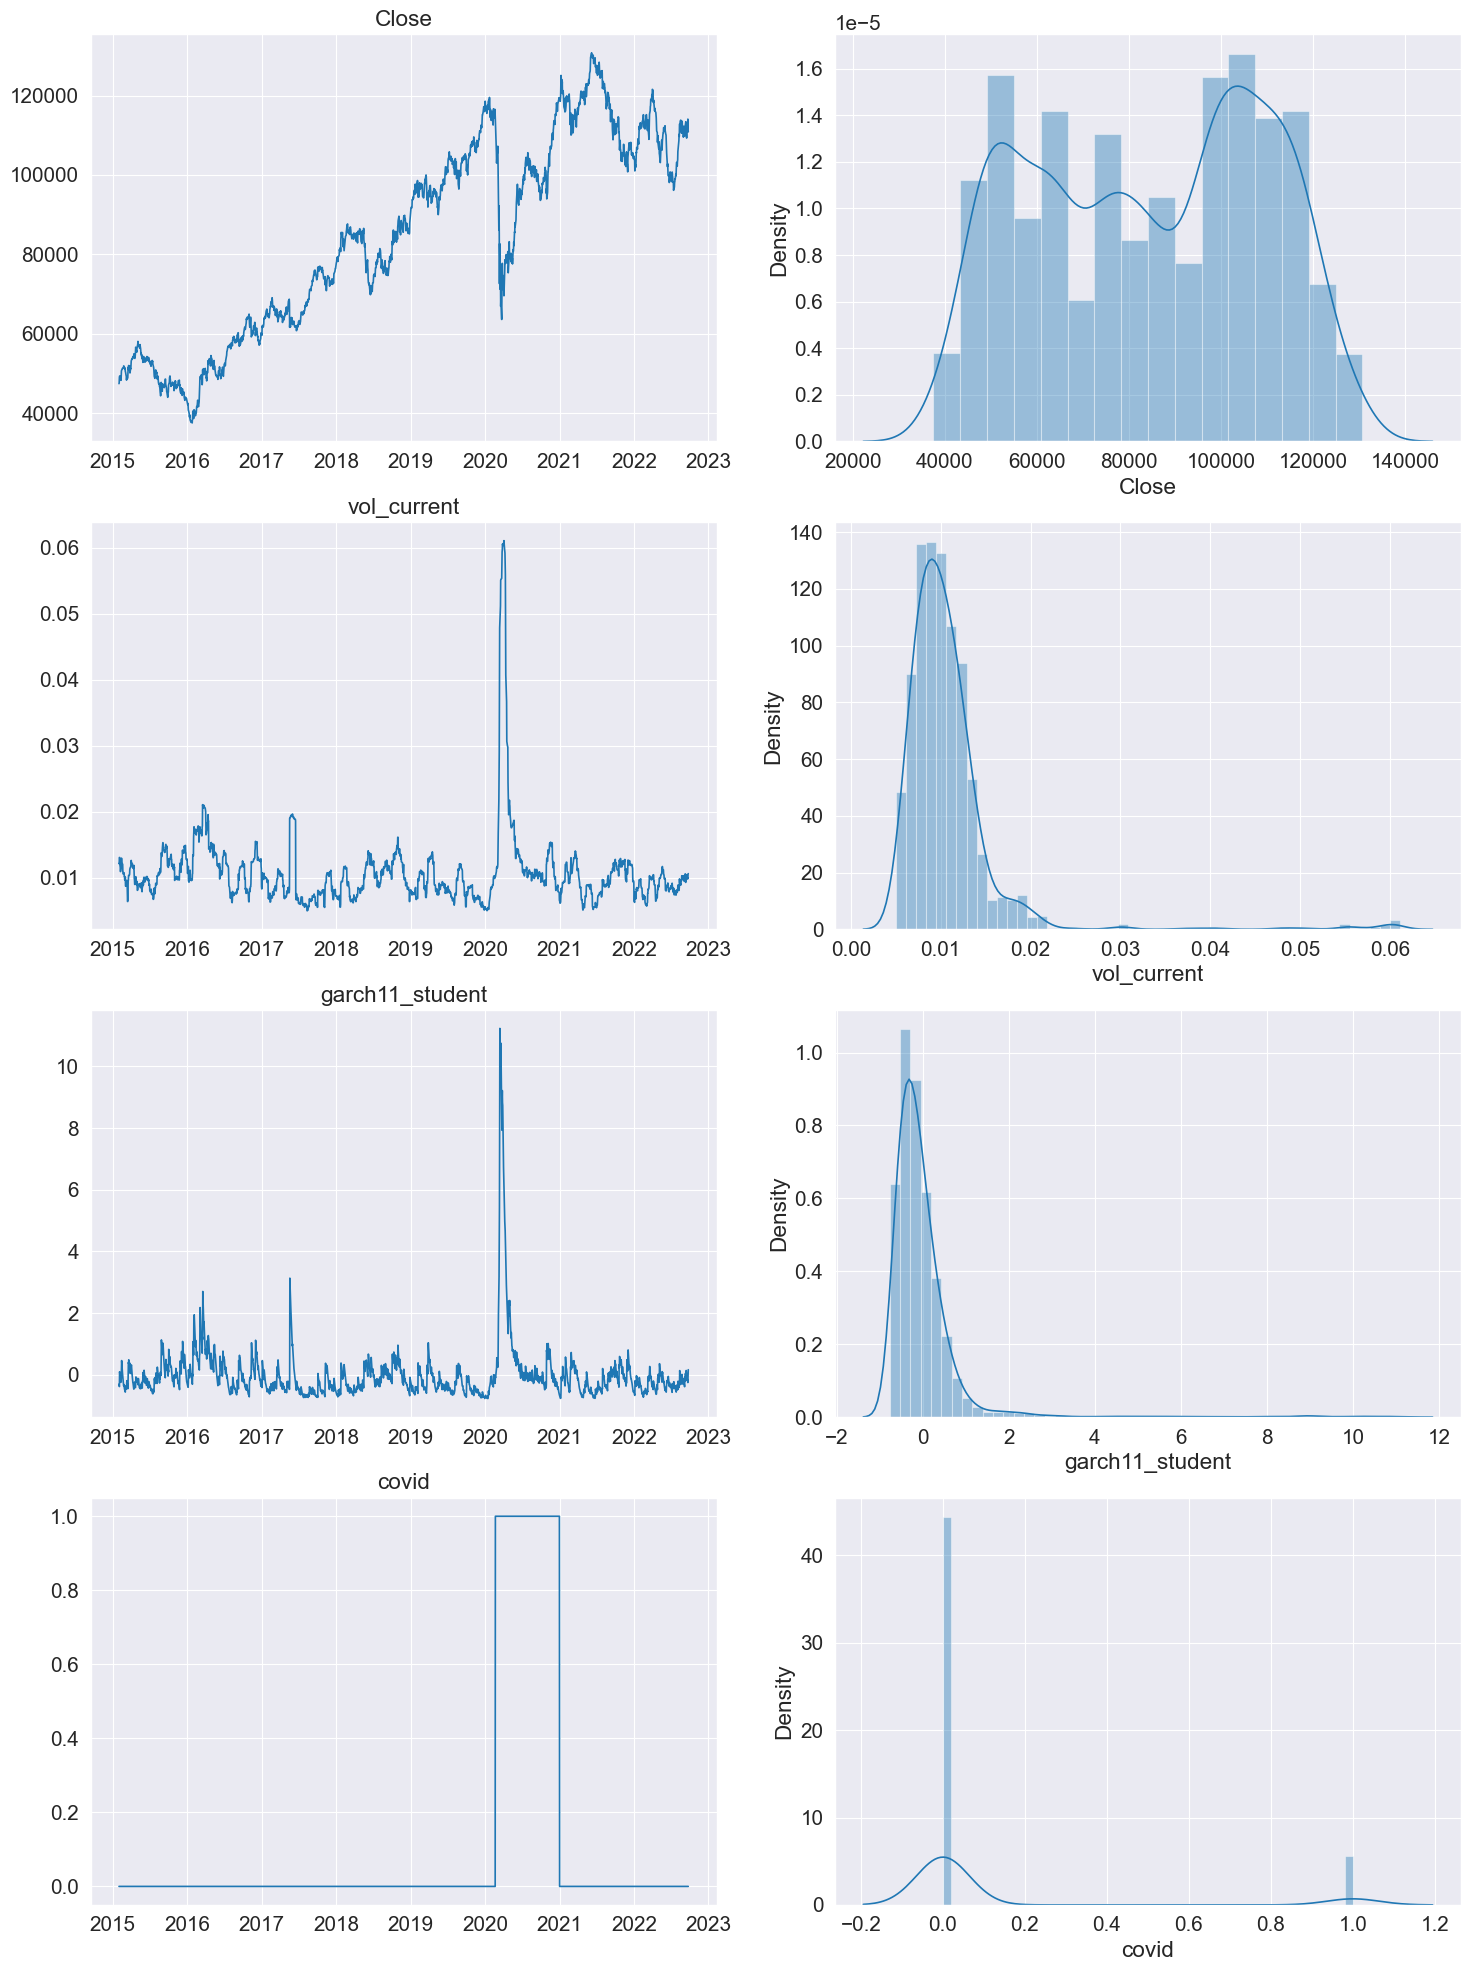

In [89]:
features = ['Close', 'vol_current', 'garch11_student', 'covid']
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(df[c])
        ax1.set_title(c)

        sns.distplot(df[c], ax=ax2)

    plt.tight_layout()
    # plt.savefig(os.path.join(directory_to_img, 'features.png'), 
    #             dpi=300, bbox_inches='tight')
    plt.show();

### REDES NEURAIS

In [261]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [262]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [263]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [264]:
# Forecast RNN
def forecast(model, range_idx, n_past):
    start_idx = range_idx[0] - timedelta(n_past -1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [265]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

In [266]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [267]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])
snn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


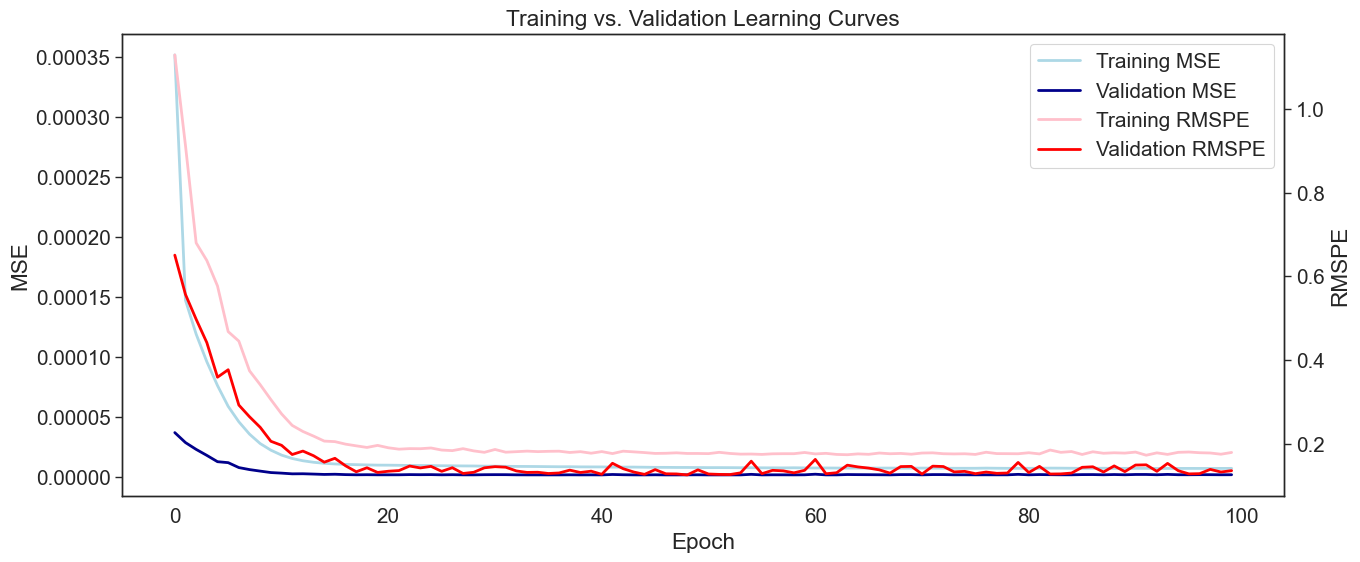

In [268]:
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)
viz_train_val_metrics(snn_1_res)

In [269]:
snn_1_preds = forecast(snn_1, val_idx, n_past=n_past)
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

12/12 [==============================] - 0s 893us/step


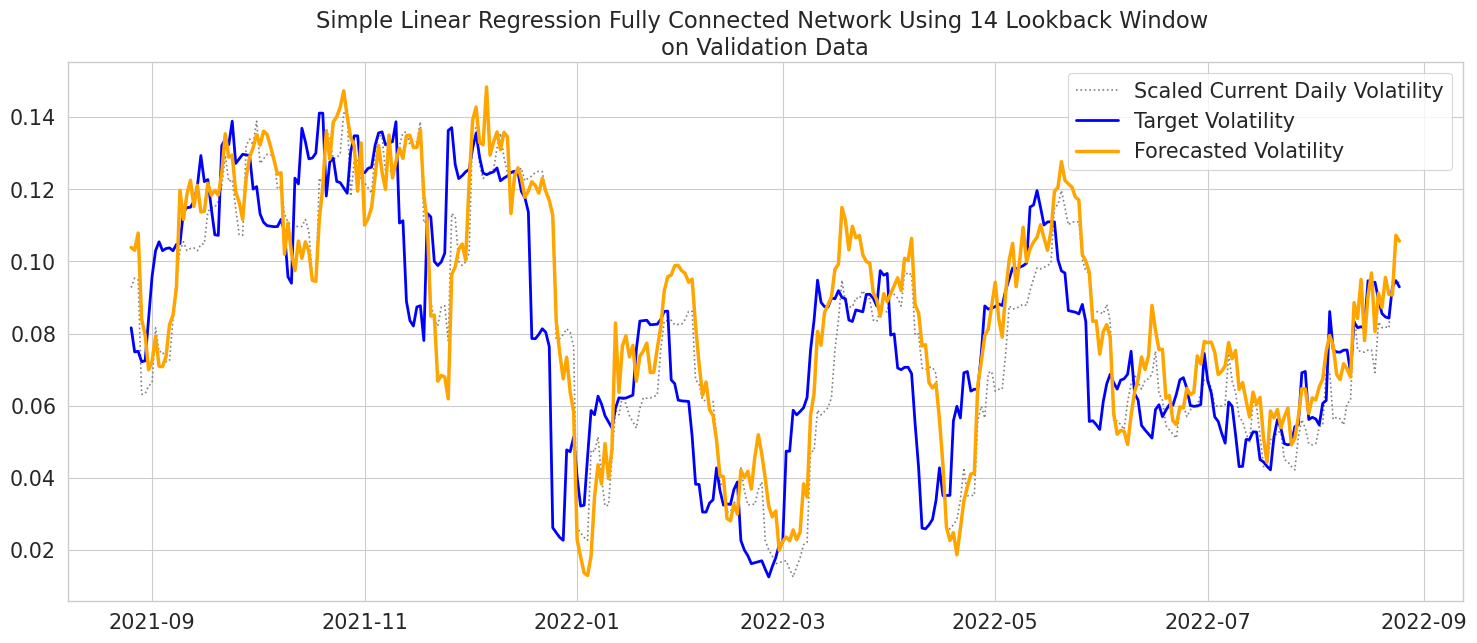

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001799,0.495983,0.042414,0.454116
"GARCH(1,1) - Student",0.001418,0.450473,0.037654,0.405811
"Simple LR Fully Connected NN, n_past=14",0.000460,0.499269,0.021444,0.295722


In [270]:
viz_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'fully_connected_NN.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

In [274]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, input_shape=[n_past], activation='relu'),                         
    #  tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

snn_2.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])
snn_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


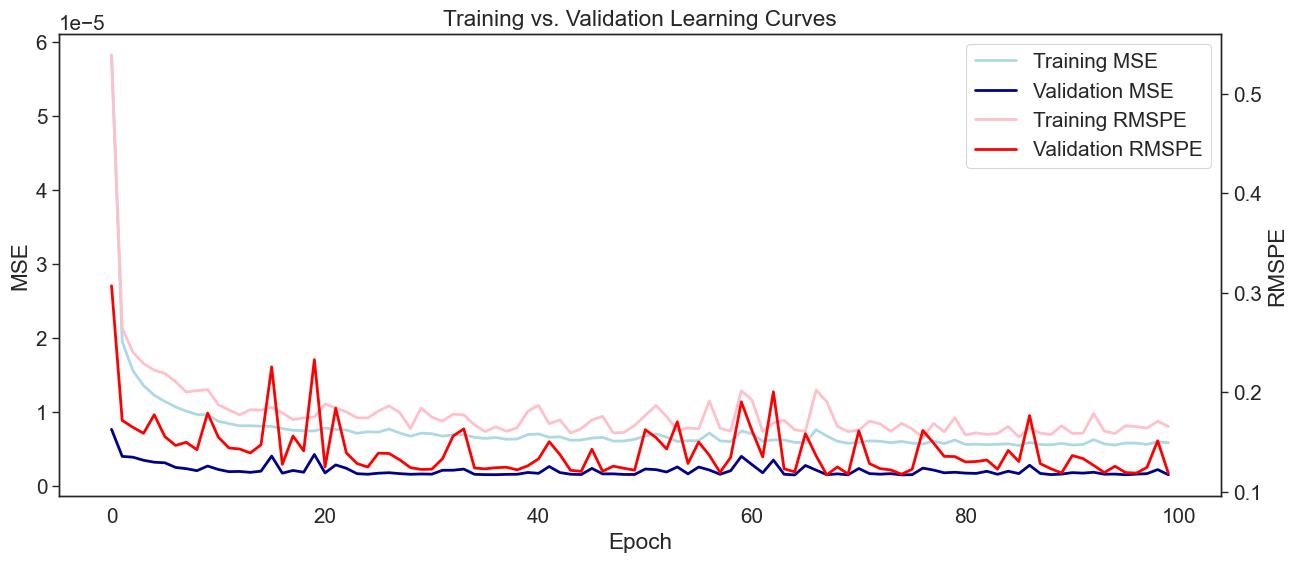

In [275]:
snn_2_res = snn_2.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)
viz_train_val_metrics(snn_2_res)

12/12 [==============================] - 0s 1ms/step


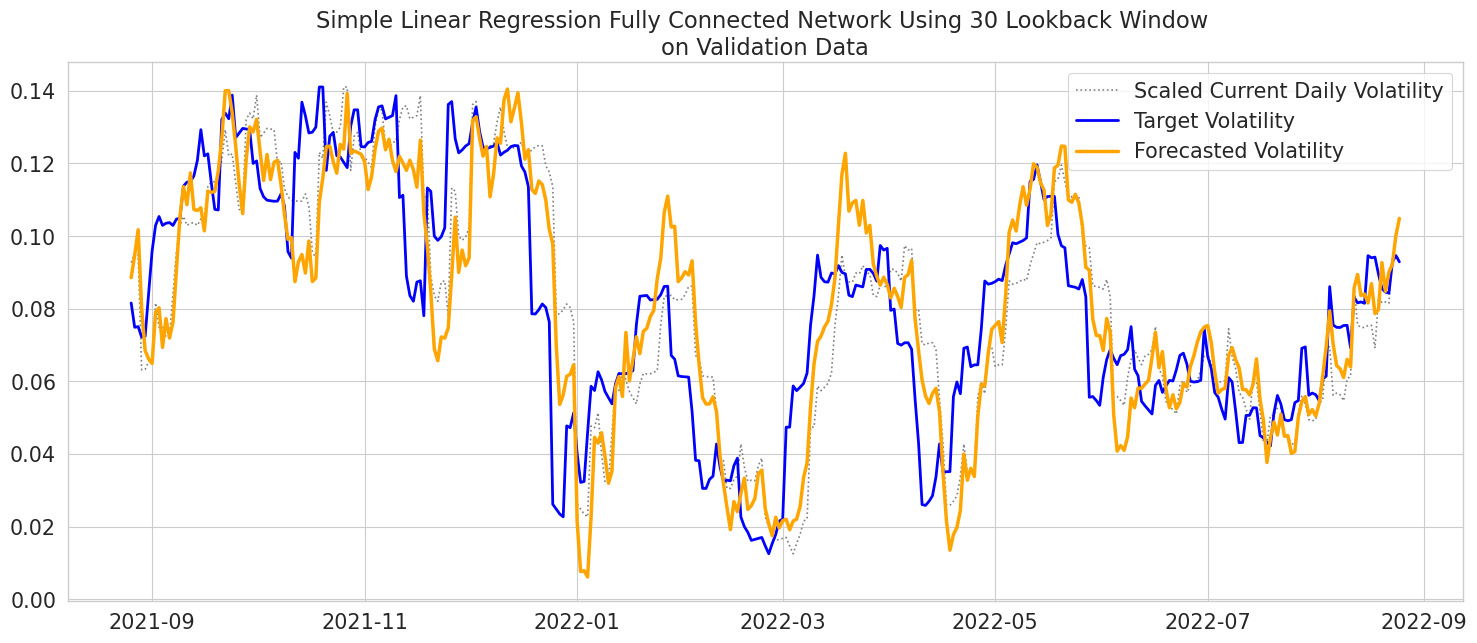

In [276]:
snn_2_preds = forecast(snn_2, val_idx, n_past=n_past)
snn_2_preds_scaled = scale(scaler_vol, snn_2_preds)
viz_model(y_val_scaled, snn_2_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'fully_connected_NN.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [277]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_2_preds_scaled,
         f"Simple LR Fully Connected NN (10x10), n_past={n_past}")

,Validation MSE,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",0.001799,0.495983,0.042414,0.454116
"GARCH(1,1) - Student",0.001418,0.450473,0.037654,0.405811
"Simple LR Fully Connected NN, n_past=14",0.000460,0.499269,0.021444,0.295722
"Simple LR Fully Connected NN (10x10), n_past=30",0.000367,0.371422,0.019149,0.243112


### LSTM


In [168]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from decimal import Decimal

In [236]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(200),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [237]:
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, 
                        shuffle=False,
                        batch_size=batch_size, 
                        epochs=100)

Epoch 1/100
30/30 [==============================] - 4s 54ms/step - loss: 6.8037e-05 - rmspe: 0.5093 - val_loss: 6.6829e-06 - val_rmspe: 0.2894
Epoch 2/100
30/30 [==============================] - 1s 36ms/step - loss: 3.0341e-05 - rmspe: 0.2977 - val_loss: 2.7756e-05 - val_rmspe: 0.6120
Epoch 3/100
30/30 [==============================] - 1s 37ms/step - loss: 2.8591e-05 - rmspe: 0.3387 - val_loss: 1.1479e-05 - val_rmspe: 0.3970
Epoch 4/100
30/30 [==============================] - 1s 39ms/step - loss: 2.0535e-05 - rmspe: 0.2652 - val_loss: 1.8050e-05 - val_rmspe: 0.4872
Epoch 5/100
30/30 [==============================] - 1s 38ms/step - loss: 2.1413e-05 - rmspe: 0.2721 - val_loss: 9.0007e-06 - val_rmspe: 0.3515
Epoch 6/100
30/30 [==============================] - 1s 38ms/step - loss: 1.7824e-05 - rmspe: 0.2569 - val_loss: 1.3482e-05 - val_rmspe: 0.4202
Epoch 7/100
30/30 [==============================] - 1s 37ms/step - loss: 1.9496e-05 - rmspe: 0.2498 - val_loss: 9.8119e-06 - val_rmspe:

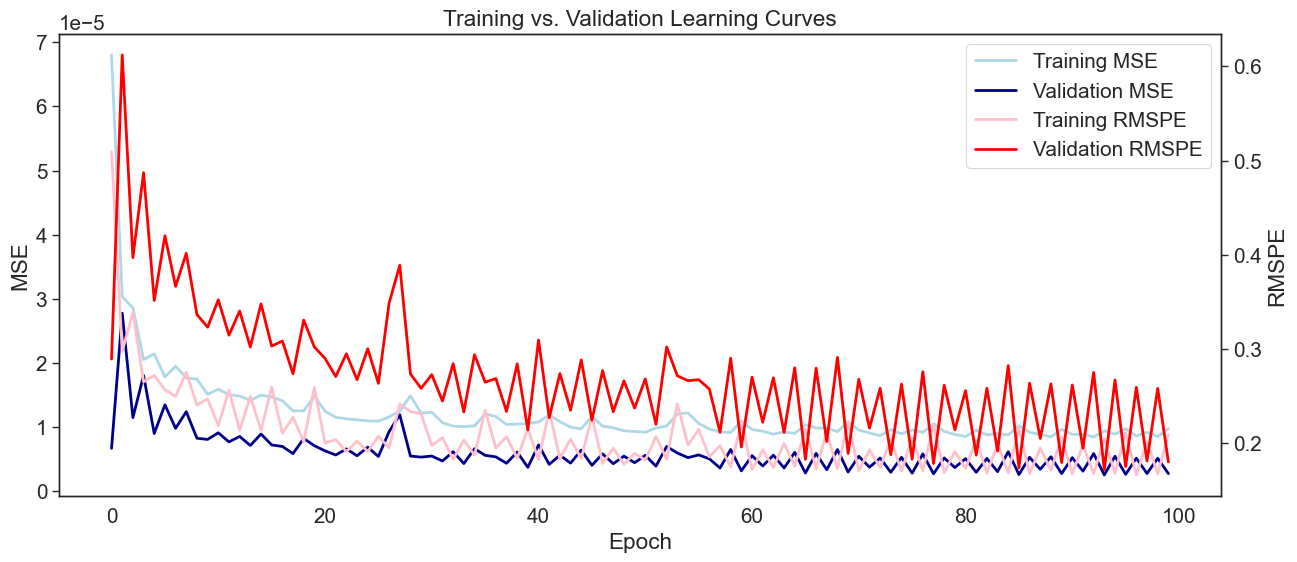

In [238]:
viz_train_val_metrics(lstm_1_res)

In [233]:
lstm_1_preds = forecast(lstm_1, val_idx, n_past=n_past)
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 [==============================] - 1s 8ms/step


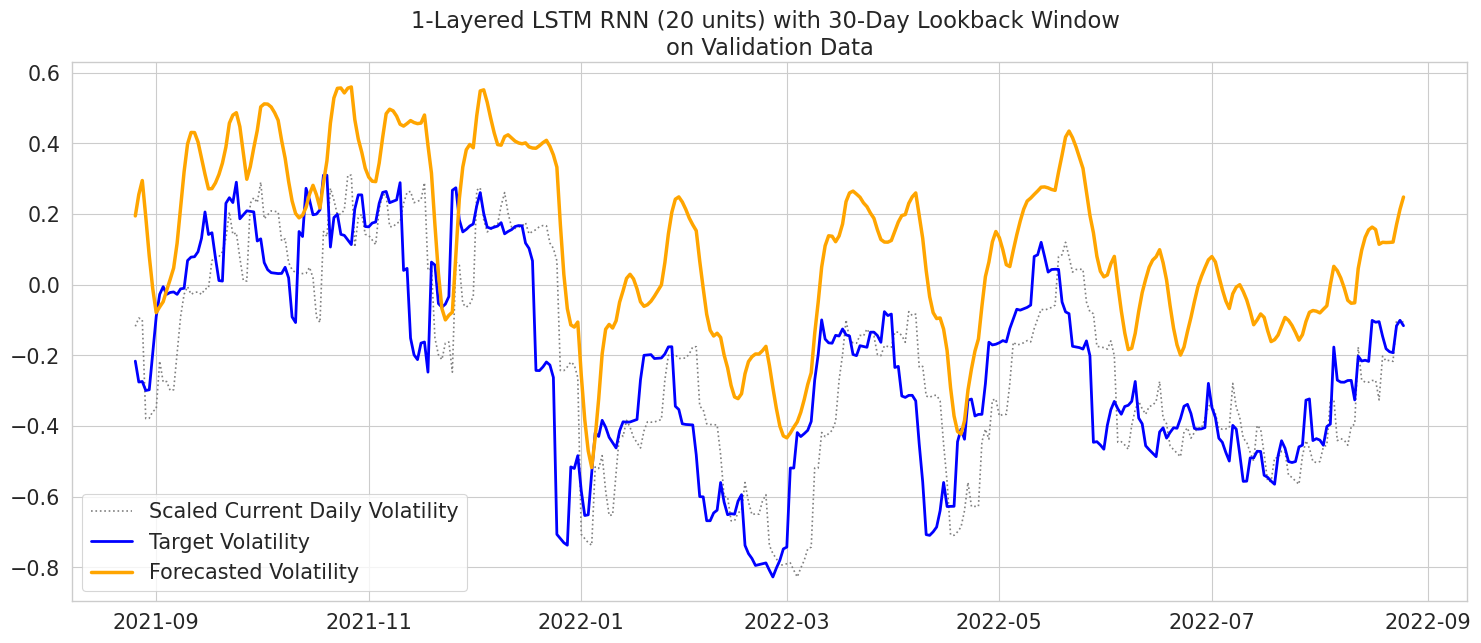

In [234]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'lstm_1.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [235]:
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units, n_past={n_past}")

,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",2.812264,0.211198,1.205000
"GARCH(1,1) - Student",2.153424,0.179761,0.969724
"Simple LR Fully Connected NN, n_past=14",2.614503,0.197581,1.070823
"LSTM 1 layer 20 units, n_past=14",3.265055,0.190424,1.084161
2 layers Bidirect LSTM (32/16 units) | n_past=30,3.272904,0.174898,1.022587
"Simple LR Fully Connected NN, n_past=60",2.388084,0.196629,1.091663
"LSTM 1 layer 20 units, n_past=60",2.066530,0.249194,1.014837
"LSTM 1 layer 20 units, n_past=30",3.994667,0.373912,2.043548


In [108]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19,105
Trainable params: 19,105
Non-trainable params: 0
_________________________________________________________________


In [117]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=False,
                        verbose=0, batch_size=batch_size, epochs=50)

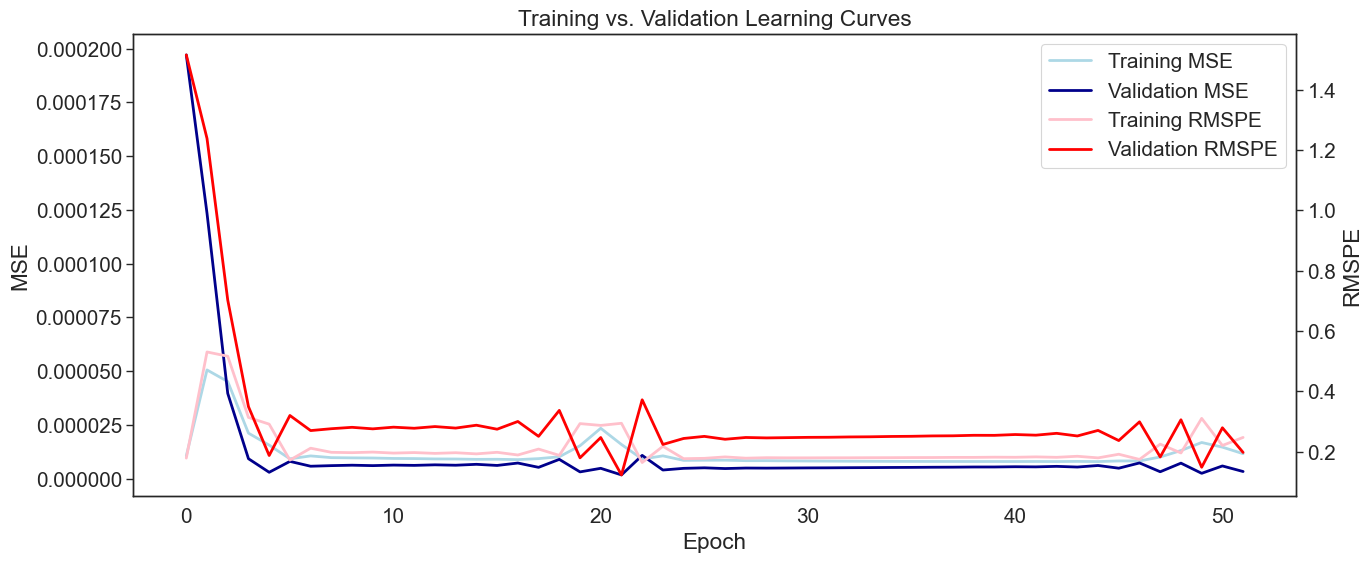

In [112]:
viz_train_val_metrics(lstm_2_res)


In [114]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast(lstm_2, val_idx,  n_past=n_past)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 [==============================] - 1s 5ms/step


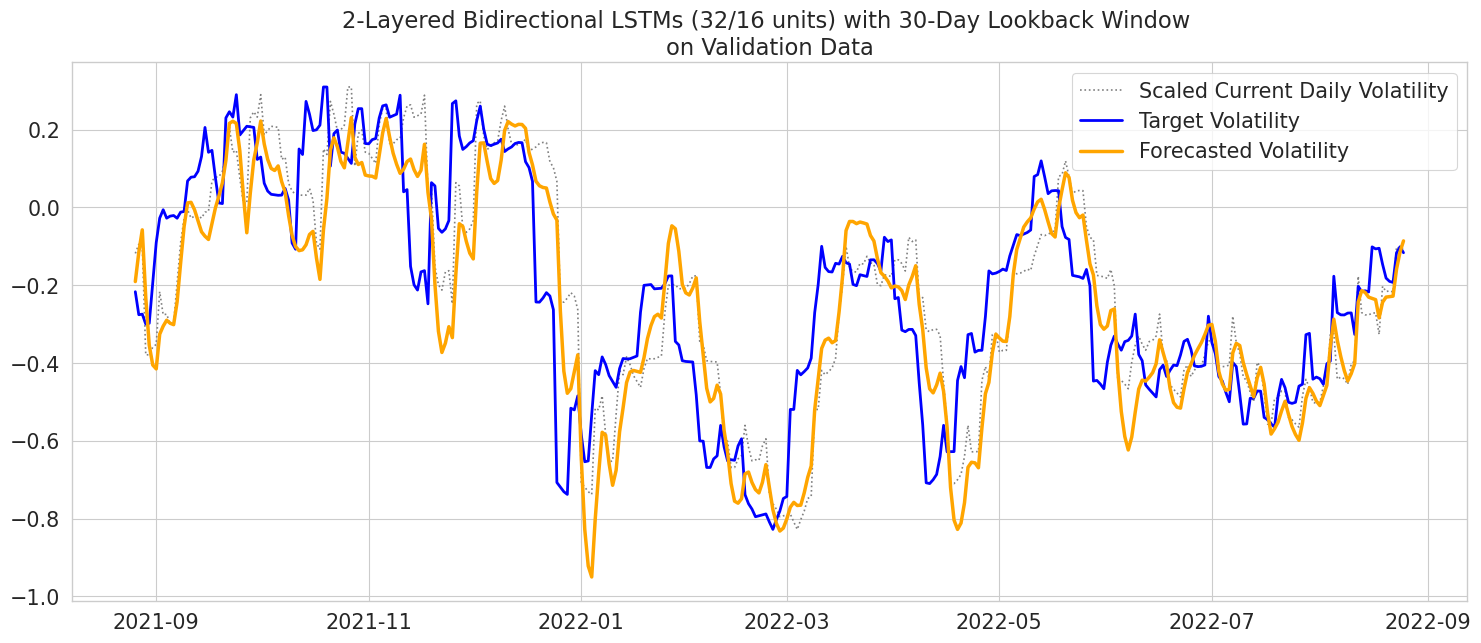

In [115]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'lstm_2.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [116]:
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units) | n_past={n_past}")

,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",2.812264,0.211198,1.205000
"GARCH(1,1) - Student",2.153424,0.179761,0.969724
"Simple LR Fully Connected NN, n_past=14",2.614503,0.197581,1.070823
"LSTM 1 layer 20 units, n_past=14",3.265055,0.190424,1.084161
2 layers Bidirect LSTM (32/16 units) | n_past=30,3.272904,0.174898,1.022587


In [145]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          160       
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 27,201
Trainable params: 27,201
Non-traina

In [146]:
# FITTING MODEL TO TRAINING DATA
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
38/38 [==============================] - 7s 31ms/step - loss: 5.3485e-05 - rmspe: 0.5420 - val_loss: 1.4734e-05 - val_rmspe: 0.5813
Epoch 2/200
38/38 [==============================] - 1s 14ms/step - loss: 4.5545e-05 - rmspe: 0.4869 - val_loss: 6.2525e-06 - val_rmspe: 0.3537
Epoch 3/200
38/38 [==============================] - 1s 13ms/step - loss: 4.3118e-05 - rmspe: 0.4816 - val_loss: 6.3858e-06 - val_rmspe: 0.3599
Epoch 4/200
38/38 [==============================] - 0s 13ms/step - loss: 4.1019e-05 - rmspe: 0.4603 - val_loss: 1.0313e-05 - val_rmspe: 0.4811
Epoch 5/200
38/38 [==============================] - 0s 13ms/step - loss: 3.9493e-05 - rmspe: 0.4611 - val_loss: 2.1781e-05 - val_rmspe: 0.6837
Epoch 6/200
38/38 [==============================] - 1s 15ms/step - loss: 3.9497e-05 - rmspe: 0.4903 - val_loss: 6.3607e-06 - val_rmspe: 0.2906
Epoch 7/200
38/38 [==============================] - 1s 13ms/step - loss: 3.5408e-05 - rmspe: 0.4464 - val_loss: 2.0579e-05 - val_rmspe:

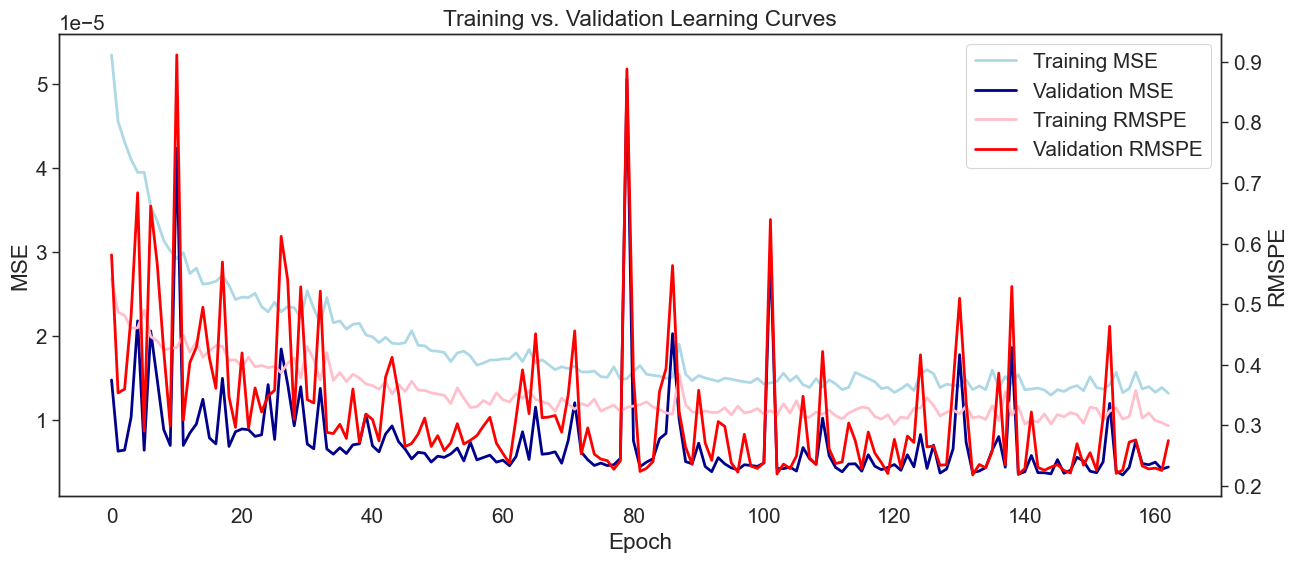

In [147]:
viz_train_val_metrics(lstm_3_res)

In [148]:
# FORECASTING ON VALIDATION SET
lstm_3_preds = forecast(lstm_3, val_idx, n_past)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)

12/12 [==============================] - 1s 3ms/step


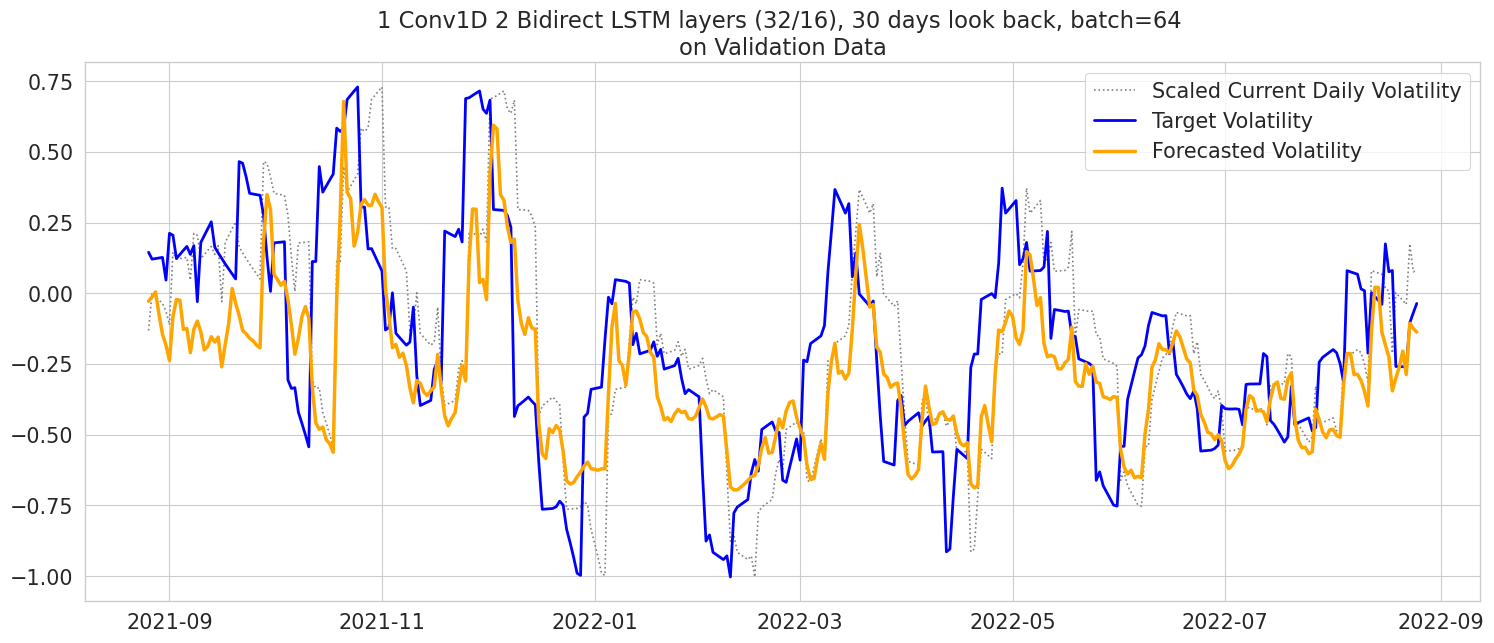

In [149]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_3_preds_scaled, 
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, batch={batch_size}")
# plt.savefig(os.path.join(directory_to_img, 'lstm_3.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [150]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled, 
         f"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past={n_past}, batch={batch_size}")

,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",33.810183,0.278488,4.132351
"GARCH(1,1) - Student",36.171421,0.289224,4.192053
"Simple LR Fully Connected NN, n_past=14",22.110758,0.311236,3.371984
"LSTM 1 layer 20 units, n_past=14",33.925002,0.311832,4.338794
2 layers Bidirect LSTM (32/16 units) | n_past=30,18.837320,0.297164,3.273421
"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=60, batch=64",38.978733,0.420654,5.954301
"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64",38.951899,0.304101,4.475656
